# Explainer Notebook

Before we get started, lets just implement all the necessary packeges.

In [2]:
# Import packages
!pip install plotly==4.9.
!pip install networkx
!pip install seaborn
#!pip install fa2
!pip install wordcloud
!pip install nltk
!pip install python-louvain
import math
import pandas as pd
import numpy as np
import urllib.request
import urllib
import re
import pickle
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
#from fa2 import ForceAtlas2
import plotly.graph_objects as go
from networkx.algorithms import community
import networkx.algorithms.community as nx_comm
import community
from community import community_louvain
from heapq import nlargest
import itertools
import ast
from collections import Counter
import glob
import os
import re
import nltk
from nltk import tokenize
from nltk.corpus import stopwords
import string
from wordcloud import WordCloud, STOPWORDS 
!pip install git+https://github.com/bhargavchippada/forceatlas2.git#egg=fa2
from fa2 import ForceAtlas2

     |████████████████████████████████| 12.9 MB 17.3 MB/s 
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11429 sha256=5c8a5fd80f21fd8b3d438e7eea8ea80f98bfd0679ebde2af57360a6150549dce
  Stored in directory: /home/jovyan/.cache/pip/wheels/f9/8d/8d/f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying
You should consider upgrading via the '/opt/venv/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 1.6 MB 19.4 MB/s 
You should consider upgrading via the '/opt/venv/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 283 kB 18.8 MB/s 
You should consider upgrading via the '/opt/venv/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 366 kB 18.4 MB/s 
You should consider upgrading via the '/opt/venv/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 1.4 MB 18.4 MB/s 
     |███████████

## 0. Table of Contents
1. Motivation
2. Data Prepocessing and Basic Stats
    - 2.1 Wikipedia 
    - 2.2 Fandom Wiki
    - 2.3 The Books
    - 2.4 The Movie Scripts
3. Tools, Theory and Analysis
    - 3.1 Degree Distribution
    - 3.2 The Houses
    - 3.4 Blood
    - 3.5 Regular Expressions 
    - 3.6 Sentiment Analysis
4. Discussion
5. Contributinos

## 1. Motivation

Our datasets are the wikikedia containing Harry Potter characters, the Fandom Harry Potter wikipages, the Harry Potter Books and the scripts for the Harry
Potter movies. We choose these particular dataset since we think that characters from a universe and their links are interesting to investigate with the help 
of graphs. The Harry Potter universe came to our minds as it is a very well know and creatly explored universe with a lot of characters and some interesting 
attributes such as the four houses at Hogwards School og Witchcraft and Wizardry and the play between different blood groups, e.g pure-bloods, half-bloods and 
muggle-born. Also the books and the movies has been read by millions and millions of people, making it interesting to look into natural language processing. 

Our goal for the end user's experience is to show them how the Harry Potter universe can be investigated and illustrated with the help of social graph analysis. 
We wish to show some hidden and confirm obvious pattern in the connection of the characters, and we wish to show a time and character perspective on the natural language pprocessing. 

## 2. Data Preprocessing and Basic Stats

For this project we will use four different data sources:

1. Wikipedia - the list of harry potter characters can be found [here](https://en.wikipedia.org/wiki/List_of_Harry_Potter_characters),
2. [Fandom Wikipedia](https://harrypotter.fandom.com/wiki/Main_Page),
3. The books - which are downloaded from [here](http://glozman.com/textpages.html), and 
4. The movie Scrips - which are found on [this](https://github.com/asmitakulkarni/QuoteGenerator/tree/master/harrypotterscripts) github.

For 1. and 2. the API, for each source, is used first to get a list of all the characters and their wiki-links and next to use these wiki-links to get the wiki-text for each character. The text from the books and the movie scrips will just be uploaded. In the below section, we will go though the data preprocessing of the four data sources and show some basic stats.


### 2.1 Wikipedia
The first data source we considered was the "normal" Wikipedia.

#### 2.1.1 Getting the data using the wiki API
A list over all the characters in Harry Potter is exstracted from (https://en.wikipedia.org/wiki/List_of_Harry_Potter_characters) wiki-page.

In [ ]:
# get wiki text with list of characters
baseurl = "https://en.wikipedia.org/w/api.php?"
action = "action=query"
content = "prop=revisions&rvprop=content"
dataformat ="format=json"
title = "titles=" + "List_of_Harry_Potter_characters"
query = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat)
wikiresponse = urllib.request.urlopen(query)
wikidata = wikiresponse.read()
wikitext = wikidata.decode('utf-8')

The character names and their corresponding wiki-link is found:

In [ ]:
# find characters in wiiki text
characters = re.findall(r'\*\[\[(?:[^|\]]*\|)?([^\]]+)\]\]', wikitext)
print('Number of characters: {}'.format(len(characters)))

Number of characters: 169


A dataframe with a row for each character is created:

In [ ]:
# Create initial dataframe with a row for each character
df = pd.DataFrame({'Name': characters, 'WikiText': None, 'Links': None})

The following function uses the charactername to find the characters wikipage and save the text in the dataframe:

In [ ]:
def getWikiData(characters):
    baseurl = "https://en.wikipedia.org/w/api.php?"
    action = "action=query"
    content = "prop=revisions&rvprop=content"
    dataformat ="format=json"

    WikiTexts = [None] * len(characters)
    for i,character in zip(range(len(characters)),characters):
        # 
        character = characters[i]
        character2 = character.replace(' ', '_')        
        title1 = "titles=" + str(character2)
        query1 = "{}{}&{}&{}&{}".format(baseurl, action, content, title1, dataformat)
        wikiresponse1 = urllib.request.urlopen(query1)
        wikidata1 = wikiresponse1.read()
        wikitext1 = wikidata1.decode('utf-8')
        temp2 = re.findall(r'\#REDIRECT \[\[(?:[^|\]]*\|)?([^\]]+)\]\]', wikitext1)
        if len(temp2) != 0:
            title2 = "titles=" + str(temp2[0].replace(' ', '_'))
            query2 = "{}{}&{}&{}&{}".format(baseurl, action, content, title2, dataformat)
            wikiresponse2 = urllib.request.urlopen(query2)
            wikidata2 = wikiresponse2.read()
            wikitext2 = wikidata2.decode('utf-8')
            temp1 = re.search(r'\=\=\={}\=\=\=(.*?).\\n\\n\=\=\='.format(character), wikitext2)
            if temp1 is None:
                temp1 = re.search(r'\\n\|-\\n\| {}(.*?).\\n\|-\\n\|'.format(character), wikitext2)
        else:
            temp1 = wikitext1
            cu = 2

        if temp1 is None:
            continue

        if cu == 2:
            #df.WikiText[i] = temp1
            WikiTexts[i] = temp1
        else:
            temp1 = temp1.group(1)
            #df.WikiText[i] = temp1
            WikiTexts[i] = temp1
            
    return WikiTexts

In [ ]:
# get wiki text
df.WikiText = getWikiData(characters)

A list of all the links in each of the characters wikitext is constructed and saved in the dataframe:

In [ ]:
# find links between characters
for i in range(len(df)):
    match = re.findall(r'\[\[(?:[^|\]]*\|)?([^\]]+)\]\]', str(df.WikiText[i]))
    #match = [x.replace(' ','_') for x in match]
    match = set(match).intersection(set(df['Name'].unique()))
    df.Links[i] = list(match)

Since the API can be a bit time consuming and we do not want to run it everytime, the dataframe is saved:

In [ ]:
# safe 
pickle.dump(df, open( "HP_wiki.p", "wb" ) )

and imported:

In [ ]:
# load dataframe
HP_wiki = pickle.load(open( "HP_wiki.p", "rb" ))

The dataframe looks as below:

In [ ]:
HP_wiki.head()

Name                                           WikiText  \
0     Hannah Abbott  \n| [[Hufflepuff]]\n| A student in Harry&#39;s...   
1       Ludo Bagman  \n'''Ludovic \"Ludo\" Bagman''' is a retired p...   
2  Bathilda Bagshot  \n&#39;&#39;&#39;Bathilda Bagshot&#39;&#39;&#3...   
3        Katie Bell  \n| [[Gryffindor]]\n| A student who joins the ...   
4    Cuthbert Binns  \n| [[Magic in Harry Potter#History of Magic|H...   

                                               Links  
0                               [Neville Longbottom]  
1                [Cedric Diggory, Augustus Rookwood]  
2  [Lord Voldemort, Rita Skeeter, Gellert Grindel...  
3                                     [Draco Malfoy]  
4                               [Minerva McGonagall]

We see that the first column contains the name of the character, the second column contains the corresponding wikitext and the third column contains the links to other characters wikipages. 

#### 2.1.2 Creating the Graph 

Now that we got a dataframe with names and links, we can construct the graph. First an empty graph is initialized:

In [ ]:
# init graph
G_wiki = nx.DiGraph()

Next the characters are added as nodes:

In [ ]:
# add nodes
for i in range(len(HP_wiki)): 
    G_wiki.add_node(HP_wiki.Name[i])

and links are added from character A to character B, if the wikipage of character A links to the wikipage of character B:

In [ ]:
# add edges 
for i in range(len(HP_wiki)):
    links = HP_wiki.Links[i]
    #print(links[0])
    for j in range(len(links)):
        #print("{}  {}".format(HP_wiki.Name[i],links[j]))
        G_wiki.add_edges_from([(HP_wiki.Name[i],links[j])])

The network is saved for later use:

In [ ]:
nx.write_gpickle(G_wiki, "G_wiki.gpickle")
G_wiki = nx.read_gpickle("G_wiki.gpickle")

We now have both a dataframe and a graph. Next we will consider some basic stats. 

#### 2.1.3 Baisc Stats

First we look at the basic stats for the dataframe

In [ ]:
print("The dataframe has {} rows.".format(len(HP_wiki)))

The dataframe has 169 rows.


Then we look at the basic stats for the associated graph

In [ ]:
# number of nodes and edges
G_wiki_nodes = G_wiki.number_of_nodes()
G_wiki_edges = G_wiki.number_of_edges()
print('The graph has {} nodes and {} edges.'.format(G_wiki_nodes,G_wiki_edges))

The graph has 169 nodes and 504 edges.


We remove the nodes that do not have any in- or outgoing edges, meaning that they do not link to any other characters and are not linked toby any other character. 

In [ ]:
G_wiki.remove_nodes_from(list(nx.isolates(G_wiki)))

G_wiki_nodes2 = G_wiki.number_of_nodes()
G_wiki_edges2 = G_wiki.number_of_edges()
print('The graph now has {} nodes and {} edges.'.format(G_wiki_nodes2,G_wiki_edges2))

The graph now has 130 nodes and 504 edges.


We will go even further and extract the giant connected component.

In [ ]:
G_wiki_dcc = [G_wiki.subgraph(c).copy() for c in nx.weakly_connected_components(G_wiki)]
G_wiki_dcc = G_wiki_dcc[0]

G_wiki_nodes3 = G_wiki_dcc.number_of_nodes()
G_wiki_edges3 = G_wiki_dcc.number_of_edges()
print('The graph now has {} nodes and {} edges.'.format(G_wiki_nodes3,G_wiki_edges3))

The graph now has 130 nodes and 504 edges.


We see no differnce. In total the number of nodes is reduced from 169 to 130.

The graph is saved for later use.

In [ ]:
nx.write_gpickle(G_wiki_dcc, "G_wiki_dcc.gpickle")
G_wiki_dcc = nx.read_gpickle("G_wiki_dcc.gpickle")

#### 2.1.4 Visualizing Graph

We visualize the undirected graph, where each character is a node and a edge is present between two nodes if one of the respective characters wikipage link to the others character. 

In [ ]:
#Make graph undirected 
G_wiki_un = G_wiki_dcc.to_undirected()
#save graph
nx.write_gpickle(G_wiki_un, "G_wiki_un.gpickle")
G_wiki_un = nx.read_gpickle("G_wiki_un.gpickle")

We use the ForceAtlas2 package to visualize the graph to avoid big blubs of nodes. We define the function.

In [5]:
from fa2 import ForceAtlas2
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=1.5,
                        strongGravityMode=False,
                        gravity=1.0,

                        # Log
                        verbose=True)


And with the function the positions of the nodes are found.

In [ ]:
positions = forceatlas2.forceatlas2_networkx_layout(G_wiki_un, pos=None, iterations=1000)

100%|██████████| 1000/1000 [00:00<00:00, 1473.96it/s]BarnesHut Approximation  took  0.12  seconds
Repulsion forces  took  0.41  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.01  seconds
AdjustSpeedAndApplyForces step  took  0.04  seconds



And the graph is depict

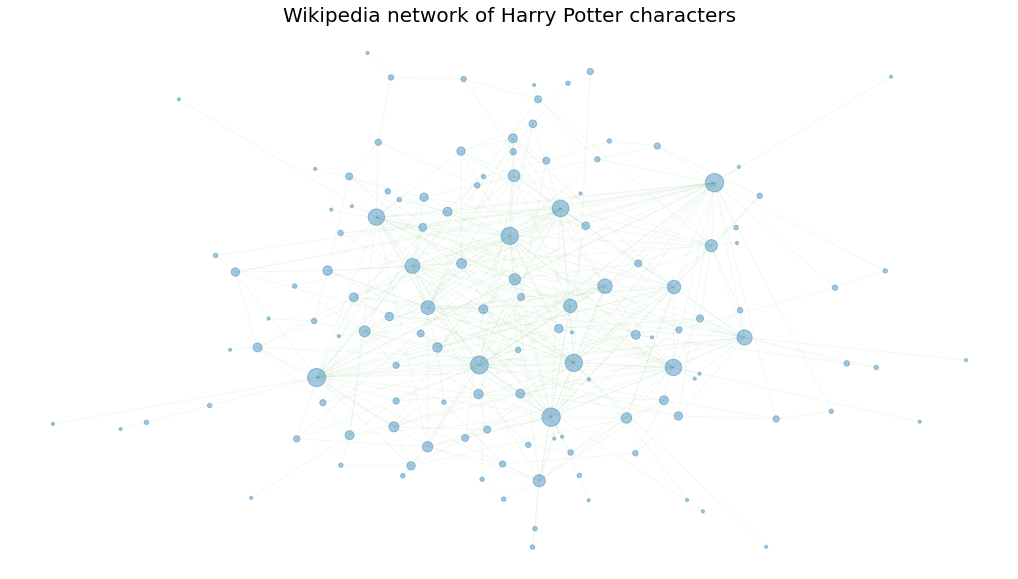

In [ ]:
d = dict(nx.degree(G_wiki_un))
n = list(d.keys())
v = list(d.values())

# change fogure size
plt.rcParams['figure.figsize'] = (18,10) 
plt.rcParams.update({'font.size': 10}) 

labels = {}
for i in range(len(n)):
    if v[i] > 200:
        labels[n[i]] = n[i]
#set the argument 'with labels' to False so you have unlabeled graph
nx.draw_networkx_nodes(G_wiki_un, positions, 
                       #nodelist = d.keys(), 
                       nodelist = list(d.keys()),
                       node_size = [v*10 for v in d.values()],
                       #node_size = [v for v in list(d.values())],
                       #node_color = list(nx.get_node_attributes(G_un,'color').values()),
                       #with_labels=False,  
                       alpha=0.4)
nx.draw_networkx_edges(G_wiki_un, positions, edge_color="green", alpha=0.05)
nx.draw_networkx_labels(G_wiki_un,positions,labels,font_size=10,font_color='r')
plt.title("Wikipedia network of Harry Potter characters", fontsize = 20)
plt.axis('off')
plt.savefig('G_wiki_un.png', bbox_inches='tight')
plt.show()

 ### 2.2 Fandom Wiki
 As seen the 'normal' wikipedia does only contain few character pages in respect to the enormous universe, we look into the [Harry Potter Fandom wiki](https://harrypotter.fandom.com/wiki/Main_Page) instead. 
 This contains a much more comprehensive base of characters from the Harry Potter universe, e.g. including characters only appearing the the games and characters from the "Fantastic beasts and where they live" series. 
 Again we want to make a dataframe with the names of character, their wikilink to their respective fandom page, the wikitext on the fandom page and links to other characters. 

#### 2.2.1 Getting the data using the Fandom wiki API

First we import a list off all characters on the Fandom wikipedia, including their links.

In [ ]:
#Load HP characters
HP_init = pd.read_csv('HPC.txt', sep='|', encoding = "cp1252")

Then nan's and duplicates are removed, and columns for the wikitext and links are created.

In [ ]:
#Drop potential NANs and duplicates.
HP_init = HP_init.dropna(how = 'any').reset_index(drop = True)
HP_init = HP_init.drop_duplicates(subset="CharacterName").reset_index(drop = True)

#Add columns
HP_init['WikiText'] = None
HP_init['Links'] = None

In [ ]:
#Check dataframe 
HP_init.head(3)

CharacterName                     WikiLink WikiText Links
0             Angus Buchanan               Angus_Buchanan     None  None
1    Bartemius Crouch Junior      Bartemius_Crouch_Junior     None  None
2  Arthur Weasley's brothers  Arthur_Weasley%27s_brothers     None  None

Above the first five rows of the dataframe is printed to check that everything looks ok. 

We are now ready to get the text from each characters fandom wikipage. First the base input to the API is defined.

In [ ]:
#Create API
baseurl = "https://harrypotter.fandom.com/api.php?"
action = "action=query"
content = "prop=revisions&rvprop=content"
dataformat ="format=json"
prop = "revision"

An output for missing text is defined to check that all pages have a content and the list above does not contain any errors in names or links.

In [ ]:
#Define output for missing text
miss = '{"warnings":{"main":{"*":"Unrecognized parameter: revision."}},"batchcomplete":"","query":{"pages":{"-1":{"ns":0,"title":"Hej","missing":""}}}}'

Now the wikitext for each character can be downloaded.

In [ ]:
# Load wikitexts and extract links
for i in range(len(HP_init)):
    title = "titles=" + str(HP_init.WikiLink[i])
    #print(title)
    query = "{}{}&{}&{}&{}&{}".format(baseurl, action, content, title, prop, dataformat)
    wikiresponse = urllib.request.urlopen(query)
    wikidata = wikiresponse.read()
    wikitext = wikidata.decode('utf-8')
    if wikitext == miss:
        print("Missed a page!")
    HP_init.WikiText[i] = wikitext
    #match = re.findall(r'\[\[(?:[^|\]]*\|)?([^\]]+)\]\]', str(HP_init.WikiText[i]))
    #match = set(match).intersection(set(HP_init['CharacterName'].unique()))
    #HP_init.Links[i] = list(match)
    #print(match)

The dataframe is saved so we do not have to run the API more than one time.

In [ ]:
#save dataframe to load later
pickle.dump(HP_init , open( "HP_init.p", "wb" ) )

And it is loaded 

In [ ]:
#load dataframe 
HP_fandom_init = pickle.load(open( "HP_init.p", "rb" ))

Some cleaning needs to be done. We remove some non-character elements since the Fandom wiki also has a page for e.g. paintings.

In [ ]:
removeList = ['Prime Minister (title)', 'Alliance','Veela','Badger','Eagle','Lion','Pukwudgie','Thunderbird','Lion','Queen', 'Count','Unicorn','Jesus','Angel','Devil','God','Wandless',
'Spellman','Queenbee','Paper-owl','Executioner','Obliviator','Unspeakable','Curse-Breaker','Magician','Theoretician','Dentist','Police','Minister','Half-giant',
'Half-goblin','Half-Veela','Half-breed','Part-troll','Part-vampire','Twins','Dragonologist','Griffin','Matagot','Sphinx','Cavalier','Crusader','Footman','Knight',
'Paladin','Squire','Swordsman','Greengrocer','Daily Prophet', 'Muggle-born', 'Un-born', 'Muggle-Born Registration Commission', 'British Ministry of Magic', 
'Professor', 'Death Eaters', 'Britannia', 'Non-magic people', 'Squib', 'Animagus', 'Healer','King', 'Chaser', 'Seeker', 'Beater', 'Quidditch Captain', 'Keeper', 
'Giant', 'Magizoologist', 'Centaur', 'Auror', 'Snatchers', 'Lestrange Vault', 'Herbologist', 'Prefect', 'Potioneer', 'American plumbers','Potions Master', 
'Slug Club', 'Order of the Phoenix', 'Snake', 'Hogwartian', 'Seer', 'Quidditch referee','Broom-maker', 'Musician', 'Troll', 'Minister for Magic', 
'Minister for Magic and Support Staff','Hogwarts Headmaster', 'Gouging Spell', 'Animagus', 'Parseltongue', 'Herbologist',  'Arithmancer','Snargaluff', 
"Dumbledore's Army", 'Broom-maker',  'Thestral', 'Dementor', 'Head of House', 'Head of Gryffindor House','Hatstall', 'House-elf', 'Prime Minister', 
'Inferius', 'Unspeakable', 'Prince', 'Astronomer','President of the United States of America', 'Spellbound (group)', 'Wandmaker']

In [ ]:
#Remove non-character elements (founded - more can occur)
df1 = HP_fandom_init[HP_fandom_init['CharacterName'].str.contains('Blood', regex=False, case=False, na=False)].reset_index(drop=True)
df1 = df1.tail(3)
df2 = HP_fandom_init[HP_fandom_init['CharacterName'].str.contains('Family', regex=False, case=False, na=False)].reset_index(drop=True)
df3 = HP_fandom_init[HP_fandom_init['CharacterName'].str.contains('House of', regex=False, case=False, na=False)].reset_index(drop=True)
df4 = HP_fandom_init[HP_fandom_init['CharacterName'].str.contains('Portrait', regex=False, case=False, na=False)].reset_index(drop=True)
df5 = HP_fandom_init[HP_fandom_init['CharacterName'].str.contains('colony', regex=False, case=False, na=False)].reset_index(drop=True)
df6 = HP_fandom_init[HP_fandom_init['CharacterName'].str.contains('Painting of', regex=False, case=False, na=False)].reset_index(drop=True)
df7 = HP_fandom_init[HP_fandom_init['CharacterName'].str.contains('Picture of', regex=False, case=False, na=False)].reset_index(drop=True)
df_remove = pd.concat([df1, df2, df3, df4, df5, df6, df7,
HP_fandom_init[HP_fandom_init.CharacterName.isin(removeList)]])

In [ ]:
HP_fandom = HP_fandom_init[~HP_fandom_init["CharacterName"].isin(list(df_remove["CharacterName"]))].reset_index(drop = True)

# Compare length of dataframes
print('Before data cleaning the data frame consisted of {} rows/character. After it consist of {}. This means that {} rows/characters where removed.'.format(len(HP_fandom_init),len(HP_fandom),len(HP_fandom_init)-len(HP_fandom)))


Before data cleaning the data frame consisted of 4350 rows/character. After it consist of 3929. This means that 421 rows/characters where removed.


And links between characters are made in the same fasion as in section 2.1.

In [ ]:
# find links between characters
for i in range(len(HP_fandom)):
    match = re.findall(r'\[\[(?:[^|\]]*\|)?([^\]]+)\]\]', str(HP_fandom.WikiText[i]))
    #match = [x.replace(' ','_') for x in match]
    match = set(match).intersection(set(HP_fandom['CharacterName'].unique()))
    HP_fandom.Links[i] = list(match)

A column is added to the dataframe cantaining the number of links for each character.

In [ ]:
HP_fandom['NumLinks'] = [len(n) for n in HP_fandom.Links]

The head of the dataframe is printed to chack that everything looks correct.

In [ ]:
HP_fandom.head()

CharacterName                     WikiLink  \
0             Angus Buchanan               Angus_Buchanan   
1    Bartemius Crouch Junior      Bartemius_Crouch_Junior   
2  Arthur Weasley's brothers  Arthur_Weasley%27s_brothers   
3              Alphard Black                Alphard_Black   
4                 Iola Black                   Iola_Black   

                                            WikiText  \
0  {"batchcomplete":"","warnings":{"main":{"*":"S...   
1  {"batchcomplete":"","warnings":{"main":{"*":"S...   
2  {"batchcomplete":"","warnings":{"main":{"*":"S...   
3  {"batchcomplete":"","warnings":{"main":{"*":"S...   
4  {"batchcomplete":"","warnings":{"main":{"*":"S...   

                                               Links  NumLinks  
0  [Angus, John Buchanan, Flora Buchanan, Mary Bu...         8  
1  [Lucius Malfoy, Sirius Black, Remus Lupin, Sev...        34  
2  [Septimus Weasley, George Weasley, Percy Weasl...        14  
3  [Pollux Black, Walburga Black, Horace Slughorn...        11  
4  [Elladora Black, Cygnus Black II, Arcturus Bla...        15

We have now constructed a dataframe with a row for each character and their respective fandom wikitext and their links to other characters. We will now look into some interesting attributes.

#### 2.2.2 Attributes

Consulting the fandom wikipages, we found that many characters was categorized by 'loyalty', 'blood', 'species', 'gender' and 'house'. Some of these will be used in later analysis. First columns in the dataframe where allocated.

In [ ]:
 # ass columns for attributes
HP_fandom['loyalty'] = None
HP_fandom['blood'] = None
HP_fandom['species'] = None
HP_fandom['gender'] = None
HP_fandom['house'] = None

Then the above mentioned attributes were extracted from the each characters wikitext.

In [ ]:
# find attributes in wiki text
for i in range(len(HP_fandom)):
    temp1 = re.findall(r'\\n\|loyalty\s\=\s\*\[\[([\w\s.-]+)', HP_fandom.WikiText[i])
    if len(temp1) > 0:
        HP_fandom['loyalty'][i] = temp1[0].lower()
    temp2 = re.findall(r'\\n\|blood\s\=\s\[\[([\w\s.-]+)', HP_fandom.WikiText[i])
    if len(temp2) > 0:
        HP_fandom['blood'][i] = temp2[0].lower()
    temp3 = re.findall(r'\\n\|species\s\=\s\[\[([\w\s.-]+)', HP_fandom.WikiText[i])
    if len(temp3) > 0:
        HP_fandom['species'][i] = temp3[0].lower()
    temp4 = re.findall(r'\\n\|gender\s\=\s([\w\s.-]+)', HP_fandom.WikiText[i])
    if len(temp4) > 0:
        HP_fandom['gender'][i] = temp4[0].lower()
    temp5 = re.findall(r'\\n\|house\s\=\s\[\[([\w\s.-]+)', HP_fandom.WikiText[i])
    if len(temp5) > 0:
        HP_fandom['house'][i] = temp5[0].lower()


Some attributes a defined manually.

In [ ]:
# Manually define
HP_fandom.loc[HP_fandom.CharacterName == "Unidentified bird in bell jar", 'species'] = "hummingbird"
HP_fandom.loc[HP_fandom.CharacterName == "Zygmunt Budge's sheep", 'species'] = "sheep"
HP_fandom.gender = HP_fandom.gender.replace("height", "male")

We will take a closer look at the distribution of these in the basic stats section. But first we create a graph of the network.

#### 2.2.3 Creating the Graph 

Now that we got a dataframe with names and links, we can construct the graph. First an ampty graph is initialized:

In [ ]:
# init graph
G_fandom = nx.DiGraph()

Then the nodes are added.

In [ ]:
# add nodes
for i in range(len(HP_fandom)): 
    G_fandom.add_node(HP_fandom.CharacterName[i], links = HP_fandom.Links[i], loyalty = HP_fandom.loyalty[i], blood = HP_fandom.blood[i], 
    species = HP_fandom.species[i], gender = HP_fandom.gender[i], house = HP_fandom.house[i], NumLinks = HP_fandom.NumLinks[i])

And last the edges are added

In [ ]:
# add edges 
for i in range(len(HP_fandom)):
    links = HP_fandom.Links[i]
    for j in range(len(links)):
        G_fandom.add_edges_from([(HP_fandom.CharacterName[i],links[j])])
#save graph
nx.write_gpickle(G_fandom, "G_fandom.gpickle")
G_fandom = nx.read_gpickle("G_fandom.gpickle")

#### 2.2.4 Baisc Stats

First we look into the basic stats of the dataframe.

In [ ]:
print("The dataframe has {} rows.".format(len(HP_fandom)))

The dataframe has 3929 rows.


##### Loyalty
Next, we take a look at the different attributes. Considering 'loyalty', we see most characters are loyal to the Hogwarts School of Witchcraft and Wizardry by far. 

In [ ]:
# considering loyalty
loyalty = HP_fandom.groupby('loyalty')['CharacterName'].nunique()
print('Characters are loyal to {} different families/institutes. {:.2f}% of them are being loyal the Hogwarts School of Witchcraft and Wizardry.'.format(len(loyalty),loyalty.sort_values(ascending = False)[0]/sum(loyalty)*100))
loyalty.sort_values(ascending = False)[0:11]

Characters are loyal to 215 different families/institutes. 46.76% of them are being loyal the Hogwarts School of Witchcraft and Wizardry.


loyalty
hogwarts school of witchcraft and wizardry    476
british ministry of magic                      91
death eaters                                   31
house of black                                 28
tom riddle                                     16
potter family                                   9
weasley family                                  9
malfoy family                                   8
order of the phoenix                            8
longbottom family                               7
lestrange family                                7
Name: CharacterName, dtype: int64

Based on loyalty, we had hoped to be able to destingues between good and evil characters, if you could even do that (Snape suddenly became good i the last book after everyone have assumed that se was evil). But e.g. the Lola Lestrange from the Fantastic Beasts series are 'good' while Bellatrix Lestrange from Harry Potter series is 'evil', thus it would not be possible to know if the characters loyal to the 'Lestrange Family' are good or evil. Next we look into blood.  

##### Blood

In [ ]:
# blood
blood = HP_fandom.groupby('blood')['CharacterName'].nunique()
blood.sort_values(ascending = False)

blood
pure-blood          391
non-magic people    286
half-blood           88
muggle-born          25
magic                20
muggle               12
squib                10
half-veela            3
part-human            2
part elf              1
no-maj                1
half-goblin           1
half-breed            1
giant                 1
Name: CharacterName, dtype: int64

We are not interested in smaller groups as giant and half-veela, thus we disregard these. Putting muggle into non-magic people, we want to consider the four big groups: pure-blood, non-magic people (and muggle), half-blood and muggle-born.

In [ ]:
HP_fandom.blood[HP_fandom.blood == 'muggle'] = 'non-magic people'
blood = HP_fandom.groupby('blood')['CharacterName'].nunique()

/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
blood.sort_values(ascending = False)[0:4]

blood
pure-blood          391
non-magic people    298
half-blood           88
muggle-born          25
Name: CharacterName, dtype: int64

We will look futher into these categories in the analysis. We will also consider the gender distribution.

##### Gender

In [ ]:
# gender
HP_fandom.gender = HP_fandom.gender.str.strip()
gender = HP_fandom.groupby(by='gender', as_index=False).agg({'CharacterName': pd.Series.nunique})
print(gender)

              gender  CharacterName
0   at least one boy              1
1             female            984
2            females              7
3               male           1669
4    male and female              1
5              males             21
6  males and females              2


Here we see that males are overrepresented. Last we consider the houses of the schools in the universe.

##### Houses

In [ ]:
# house
houses = HP_fandom.groupby('house')['CharacterName'].nunique()
houses.sort_values(ascending = False)

house
gryffindor         272
slytherin          241
hufflepuff         175
ravenclaw          165
thunderbird          1
pukwudgie            1
horned serpent       1
Name: CharacterName, dtype: int64

In [ ]:
#save dataframe to load later
pickle.dump(HP_fandom , open( "HP_fandom1.p", "wb" ) )

In the analysis we will be looking into the four houses Gryffindor, Hufflepuff, Ravenclaw  and Slytherin. 

Next we consider some basic stats of the graps. 

##### Graph

In [ ]:
# number of nodes and edges
G_fandom_nodes = G_fandom.number_of_nodes()
G_fandom_edges = G_fandom.number_of_edges()
print('The initial graph has {} nodes and {} edges.'.format(G_fandom_nodes,G_fandom_edges))

The initial graph has 3929 nodes and 14911 edges.


Instead of only excluding characters whos wikipages to not link to any other characters pages and vice versa, we extract the giant connected component.

In [ ]:
#G_fandom_dcc = G_fandom
#G_fandom_dcc.remove_nodes_from(list(nx.isolates(G_fandom_dcc)))
# extract giant component 
G_fandom_dcc = [G_fandom.subgraph(c).copy() for c in nx.weakly_connected_components(G_fandom)]
G_fandom_dcc = G_fandom_dcc[0]

nx.write_gpickle(G_fandom_dcc, "G_fandom_dcc.gpickle")

G_fandom_nodes2 = G_fandom_dcc.number_of_nodes()
G_fandom_edges2 = G_fandom_dcc.number_of_edges()
print('The graph now has {} nodes and {} edges.'.format(G_fandom_nodes2,G_fandom_edges2))

The graph now has 2642 nodes and 14520 edges.


As we later need the dataframe as a reference for the giant component graph, a new dataframe only containing the characters in the giant component is made.

In [ ]:
G_fandom_un = G_fandom_dcc.to_undirected()
nx.write_gpickle(G_fandom_dcc, "G_fandom_un.gpickle")

#find characters not in communities
not_in = list(set(list(HP_fandom["CharacterName"])) - set(list(G_fandom_un.nodes())))          
#Create community dataframe
HP_fandom_dcc = HP_fandom[~HP_fandom["CharacterName"].isin(not_in)].reset_index(drop=True)

The list of links for each character is then remade to only containing the characters in the giant component. 

In [ ]:
#Find links 
for i in range(len(HP_fandom_dcc)):
    match = re.findall(r'\[\[(?:[^|\]]*\|)?([^\]]+)\]\]', str(HP_fandom_dcc.WikiText[i]))
    match = set(match).intersection(set(HP_fandom_dcc['CharacterName'].unique()))
    HP_fandom_dcc.Links[i] = list(match)

#save dataframe to load later
pickle.dump(HP_fandom_dcc , open( "HP_fandom_dcc.p", "wb" ) )

Comparing the graph of the 'normal' wiki with that of the fandom wiki
we have 130 nodes compared to 2642 in the giant connected component and 504 edges compared with 14520.

#### 2.2.5 Visualizing Graphs

Like in the previous section, we use the ForceAtlas2 package. Initializing:

In [ ]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=1.5,
                        strongGravityMode=False,
                        gravity=1.0,

                        # Log
                        verbose=True)

In [ ]:
positions = forceatlas2.forceatlas2_networkx_layout(G_fandom_un, pos=None, iterations=2000)

100%|██████████| 2000/2000 [01:46<00:00, 18.87it/s]BarnesHut Approximation  took  40.70  seconds
Repulsion forces  took  60.47  seconds
Gravitational forces  took  0.29  seconds
Attraction forces  took  0.55  seconds
AdjustSpeedAndApplyForces step  took  1.43  seconds



Below, the graph is depicted. The names of the seven most connected characters have labeled notes. 

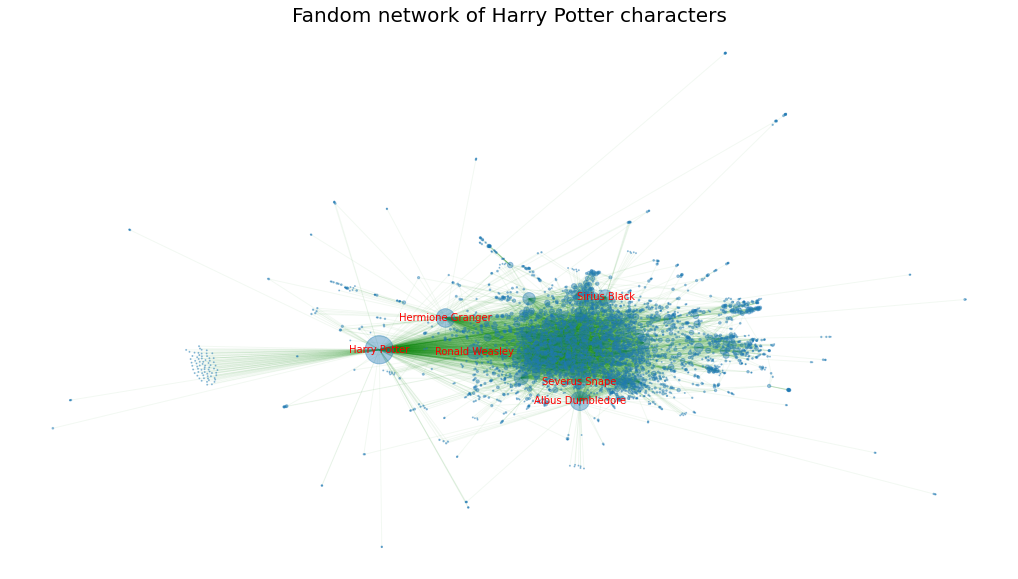

In [ ]:
d = dict(nx.degree(G_fandom_un))
n = list(d.keys())
v = list(d.values())

plt.rcParams['figure.figsize'] = (18,10) 
plt.rcParams.update({'font.size': 10}) 

labels = {}
for i in range(len(n)):
    if v[i] > 200:
        labels[n[i]] = n[i]
#set the argument 'with labels' to False so you have unlabeled graph
nx.draw_networkx_nodes(G_fandom_un, positions, 
                       #nodelist = d.keys(), 
                       nodelist = list(d.keys()),
                       node_size = [v for v in d.values()],
                       #node_size = [v for v in list(d.values())],
                       #node_color = list(nx.get_node_attributes(G_un,'color').values()),
                       #with_labels=False,  
                       alpha=0.4)
nx.draw_networkx_edges(G_fandom_un, positions, edge_color="green", alpha=0.05)
nx.draw_networkx_labels(G_fandom_un,positions,labels,font_size=10,font_color='r')
plt.title("Fandom network of Harry Potter characters", fontsize = 20)
plt.axis('off')
plt.savefig('G_fandom_un.png', bbox_inches='tight')
plt.show()

We see a big amount of nodes, many of them close together. The seven most connected characters are all well known characters. 
To be able to investigate such a big graph better, we will create an interactive graph where you will be able to hover over all nodes to see infomation about the character and be able to zoom in.

##### 2D Interactive visualization

The interactive graph is made with plotly and are heavily inspired by https://plotly.com/python/network-graphs/ and https://deepnote.com/article/3d-network-visualisations-in-deepnote/. 

The ForceAtlas2 layout of the graph is used again. First the x- and y-cooordinate for each node are listed in two variables.


In [ ]:
#Find x and y coordinate for each node
keys = list(positions.keys())
x_nodes = [positions[k][0] for k in keys]# x-coordinates of nodes
y_nodes = [positions[k][1] for k in keys]# y-coordinates

As for the nodes, we also need to find the the x- and y-coordinates for starting and ending point of each node. For this we use the egdde_list.


In [ ]:
#Find x and y coordinate for starting and ending coordinates of each edge.
edge_list = G_fandom_un.edges()
x_edges=[]
y_edges=[]

#need to fill these with all of the coordiates
for edge in edge_list:
    #format: [beginning,ending,None]
    x_coords = [positions[edge[0]][0],positions[edge[1]][0],None]
    x_edges += x_coords

    y_coords = [positions[edge[0]][1],positions[edge[1]][1],None]
    y_edges += y_coords


The nodes and the edges in the graph have to be translated into plotly variables.
We make a trace variable that find the positions of each node and edge and define the layout of these. 
A hover is defined for each node, coontaining the name of the character and names of all links. 
The nodes are colored w.r.t the number of links and a colorbar are applied.

In [ ]:
#create a trace for the edges
trace_edges = go.Scatter(x=x_edges,
                        y=y_edges,
                        mode='lines',
                        line=dict(
                            color='darkgreen',
                            width= 0.8),
                        opacity = 0.5,
                        hoverinfo='none')

#Create information for each hover.
d = dict(nx.degree(G_fandom_un))
n = list(d.keys())
v = list(d.values())
hoverList = []
bl = np.linspace(8,200,25)
for i in range(len(list(G_fandom_un.nodes()))):
    n = list(G_fandom_un.nodes())[i]
    l = list(nx.get_node_attributes(G_fandom_un,'links').values())[i]
    if len(l) == 0:
         hoverList.append('Name: ' + n)
    else:
        tmp_hover = 'Name: ' + n + '<br>Links: <br> '
        for j, li in enumerate(l):
            if j in bl:
                tmp_hover = tmp_hover + '<br>' 
            if j == len(l)-1:
                tmp_hover = tmp_hover + li
            else:
                tmp_hover = tmp_hover + li + ', '
        hoverList.append(tmp_hover)
#linkList = ['# Links: ' + str(l) for l in list(nx.get_node_attributes(G_fandom_un,'NumLinks').values())]
#nameList = ['Name: ' + n for n in list(G_fandom_un.nodes())]
#hoverList = [nameList[i] + '<br>' + linkList[i] for i in range(len(linkList))]

#create a trace for the nodes
trace_nodes = go.Scatter(x=x_nodes,
                         y=y_nodes,
                        mode='markers',
                        marker=dict(symbol='circle',
                                    size = 4,
                                    #size= [v / 8 for v in d.values()],
                                    colorscale='RdBu',
                                    reversescale = True,
                                    colorbar=dict(
                                            thickness=15,
                                            title='Node Connections',
                                            xanchor='left',
                                            titleside='right'
                                    ),
                                    ),
                        text= hoverList,
                        hoverinfo='text')

#List of colors for the nodes
trace_nodes.marker.color = list(nx.get_node_attributes(G_fandom_un,'NumLinks').values())

As we do not want axis on the plot these are removed.

In [ ]:
#we need to set the axis for the plot 
axis = dict(showbackground=False,
            showline=False,
            zeroline=False,
            showgrid=False,
            showticklabels=False,
            title='')
            

The interactive plot is then made and the layout of the whole plot is set. 
The figure is shown in this notebook and outputted as a html file for use on github page.

In [ ]:
#Make interactave graph
fig = go.Figure(data=[trace_edges, trace_nodes],
             layout=go.Layout(
                title='Network of Harry Potter Universe',
                titlefont_size=16,
                showlegend=False,
                plot_bgcolor= 'rgba(0,0,0,0)',
                hovermode='closest',
                margin=dict(b=10,l=5,r=5,t=30),
                #annotations=[ dict(
                #    text="Harry Potter fandom character pages: <a href=https://harrypotter.fandom.com/wiki/Category:Individuals'> https://harrypotter.fandom.com/wiki/Category:Individuals/</a>",
                #    showarrow=False,
                #    xref="paper", yref="paper",
                #    x=0.005, y=-0.002)],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
fig.show()
fig.write_html("Network-of-Harry-Potter-Universe.html")

To make it easy  to use the interactive graph afterwards the above code is combined to a function.

In [8]:
def intergraph(graph, pos, edgeops, nodeops, nodehover, nodecolor, titletext, colors):
    keys = list(positions.keys())
    x_nodes = [positions[k][0] for k in keys]# x-coordinates of nodes
    y_nodes = [positions[k][1] for k in keys]# y-coordinates
    #We also need a list of edges to include in the plot
    edge_list = graph.edges()
    #we  need to create lists that contain the starting and ending coordinates of each edge.
    x_edges=[]
    y_edges=[]

    #need to fill these with all of the coordiates
    for edge in edge_list:
        #format: [beginning,ending,None]
        x_coords = [positions[edge[0]][0],positions[edge[1]][0],None]
        x_edges += x_coords

        y_coords = [positions[edge[0]][1],positions[edge[1]][1],None]
        y_edges += y_coords

    #create a trace for the edges
    trace_edges = go.Scatter(x=x_edges,
                            y=y_edges,
                            mode='lines',
                            line=dict(
                                color=edgeops[0],
                                width = edgeops[1]),
                            opacity = edgeops[2],
                            hoverinfo='none')


    #create a trace for the nodes
    trace_nodes = go.Scatter(x=x_nodes,
                         y=y_nodes,
                        mode='markers',
                        marker=dict(symbol='circle',
                                    #size= [v / 8 for v in d.values()],
                                    size = nodeops[0],
                                    colorscale=colors,
                                    reversescale = True
                                    ),
                        text= nodehover,
                        hoverinfo='text')

    trace_nodes.marker.color = nodecolor
    #we need to set the axis for the plot 
    axis = dict(showbackground=False,
            showline=False,
            zeroline=False,
            showgrid=False,
            showticklabels=False,
            title='')
    fig = go.Figure(data=[trace_edges, trace_nodes],
             layout=go.Layout(
                title=titletext,
                titlefont_size=16,
                showlegend=False,
                plot_bgcolor='rgba(0,0,0,0)',
                hovermode='closest',
                margin=dict(b=10,l=5,r=5,t=30),
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
    fig.show()
    titlehtml = titletext.replace(" ", "-")
    fig.write_html(titlehtml + '.html')

### 2.3 The Books
To be able to do further text analysis, the 7 Harry Potter books are also considered.

In [ ]:
HP_books = [] 
for i in range(1,8):
    reads = 'HP' + str(i) + '_book.txt'
    with open(reads,'r',encoding="cp1252", errors='ignore') as file:
        HP_books.append(file.read())
    print("Book {} has {} characters.".format(i,len(HP_books[i-1])))

#cp1252

Book 1 has 442745 characters.
Book 2 has 489726 characters.
Book 3 has 612452 characters.
Book 4 has 1106772 characters.
Book 5 has 1481771 characters.
Book 6 has 985606 characters.
Book 7 has 1132556 characters.


Overall, we see an increase in the number of characters in the books. In the analysis section, we will be looking into sentiment analysis over time. 

### 2.4 The Movie Scripts
Also the movie scipts from the Harry Potter movies are considered for the purpose of text analysis. 

In [ ]:
HP_movies = [] 
for i in range(1,9):
    if i == 5:
        HP_movies.append(None)
        continue
    reads = 'HP' + str(i) + '_movie.txt'
    with open(reads,'r',encoding="utf-8", errors='ignore') as file:
        HP_movies.append(file.read())
    print("Movie {} has {} characters.".format(i,len(HP_movies[i-1])))

Movie 1 has 100319 characters.
Movie 2 has 81771 characters.
Movie 3 has 59623 characters.
Movie 4 has 74818 characters.
Movie 6 has 75543 characters.
Movie 7 has 68080 characters.
Movie 8 has 174720 characters.


Like with the books, we will in the analysis section be looking into sentiment analysis over time but also between characters.

## 3. Tools, theory and analysis.

Several analysix will be made. In section 3.1, we will look into the degree distribution of the graph over the Fandom Harry Potter network. 
We will be comparing the in- and out-degree distribution to that of a scale free and a random network. 
In section 3.2, we will considering a graph only with the characters from the four houses at Hogawrts. 
Within this network, we wish to investigate the number of edges between the houses and within each house. Maybe we can see a seperation between the houses.
In section 3.3, we will do the same as for the houses but for the four main blood-distinguishes.
In section 3.4, we look into communities within the Fandom Harry Potter graph and see if any interesting communities arrives.
In the last section, we will deepdive into natural language processing within the Fandom wiki, the books and the movies. 
We will consider it both on a time scale but also between characters.

### 3.1 Degree Distributions

We are intereseted in the degree distribution of the network, since it tells us something about the behavior and the properties of the network. 
We will be comparing the degree distribution of the network to that of a random network and that of a scale free network. 
Here the definitions and theory from chapter 3 and 4 in the [Network Science book](http://networksciencebook.com/chapter/3#random-network) will be used. 
In a random network each pair of $N$ nodes is connected with probability $p$. It can be shown that the degree distribution in a random network follow a poisson distribution.
Here the networks nodes as degrees in the range $k = \langle k\rangle\pm\langle k\rangle^{1/2}$. This is not there case with the scale free network.
Here the degree distribution can be approximated by the power law: $p_k\sim k^{-\gamma}$. 
In this case the second order moment is unbounded meaning that we do not know what to expect: The selected node’s degree could be zero or arbitrary large. 

First, we take a look at the most connected characters and how many links they have - both for in- and out-degrees. 

In [ ]:
most_connected_in = sorted(dict(G_fandom_dcc.in_degree()).items(), key = lambda x : x[1], reverse = True)[:5]
for i in range(1,6):
    print('{}: {}'.format(i,most_connected_in[i-1]))

1: ('Harry Potter', 787)
2: ('Hermione Granger', 330)
3: ('Albus Dumbledore', 316)
4: ('Sirius Black', 185)
5: ('Severus Snape', 177)


We see that the character most other characters link to is Harry Potter (surprise). Number two to five is also big characters in the Harry Potter Universe. 
One notices that the number of other characters linking to Harry Potter is more than twice as big as for Hermione Granger (number two). 
It makes sense that most characters from the Harry Potter Books link to Harry Potter. 

We do the same for the out-degree distribution.

In [ ]:
most_connected_out = sorted(dict(G_fandom_dcc.out_degree()).items(), key = lambda x : x[1], reverse = True)[:5]
for i in range(1,6):
    print('{}: {}'.format(i,most_connected_out[i-1]))

1: ('Albus Dumbledore', 183)
2: ('Harry Potter', 162)
3: ('Ronald Weasley', 126)
4: ('Tom Riddle', 124)
5: ('Hermione Granger', 115)


We see that Albus Dumbledore is the character that links to most other characters closely followed by Harry Potter. 
Next we see Ronald Weasley and Tom Riddle who we did not see in top five for the in-degree distribution. 
The fact makes great sense for Voldemort (Tom Riddle). He have killed a lot of people, which could be presented in these outgoing links.

We take a closer look at the in- and out-degree distribution by plotting them. First we extract all the degrees.

In [ ]:
deg_in = G_fandom_dcc.in_degree()
deg_in = np.asarray(deg_in)
degree_in = deg_in[:,1]
degrees_in = [int(x) for x in degree_in]
print('The minimum in-degree is {} and the maximum in-degree is {}.'.format(min(degrees_in),max(degrees_in)))

The minimum in-degree is 0 and the maximum in-degree is 787.


In [ ]:
deg_out = G_fandom_dcc.out_degree()
deg_out = np.asarray(deg_out)
degree_out = deg_out[:,1]
degrees_out = [int(x) for x in degree_out]
print('The minimum out-degree is {} and the maximum out-degree is {}.'.format(min(degrees_out),max(degrees_out)))

The minimum out-degree is 0 and the maximum out-degree is 183.


Following the introduction to this section, the network’s nodes should have degrees in the range $k = \langle k\rangle \pm \langle k\rangle ^{1/2}$, 
if the network is a random network. We look into this range.

In [ ]:
deg = G_fandom_dcc.degree()
deg = np.asarray(deg)
degree = deg[:,1]
degrees = [int(x) for x in degree]
k_ave = sum(degrees)/len(degrees)
print('The average degree is {:.2f}. If it is a random network, the nodes should have in-degrees within [{:.2f}, {:.2f}].'.format(k_ave,k_ave-k_ave**(1/2),k_ave+k_ave**(1/2)))

The average degree is 10.99. If it is a random network, the nodes should have in-degrees within [7.68, 14.31].


By looking at the top five in and out degrees, it is clear that the degree of the nodes can not be expected to lie within the above range. 
Thus the network does not seem to be a random network. To make this clear, we plot both the in- and out-degree distribution.

##### Plot in-degree distribution
We plot the in-degree distribution both as a histogram and in a loglog scale.

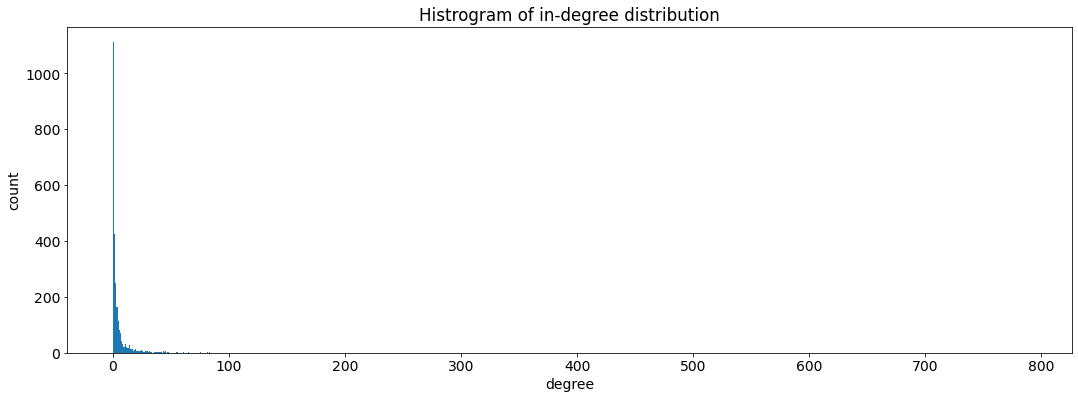

In [ ]:
plt.rcParams['figure.figsize'] = (18, 6) 
plt.rcParams.update({'font.size': 14}) 
plt.hist(degrees_in,bins=max(degrees_in)+1)
plt.xlabel('degree')
plt.ylabel('count')
plt.title('Histrogram of in-degree distribution')
plt.savefig("histindegree.png")
plt.show()

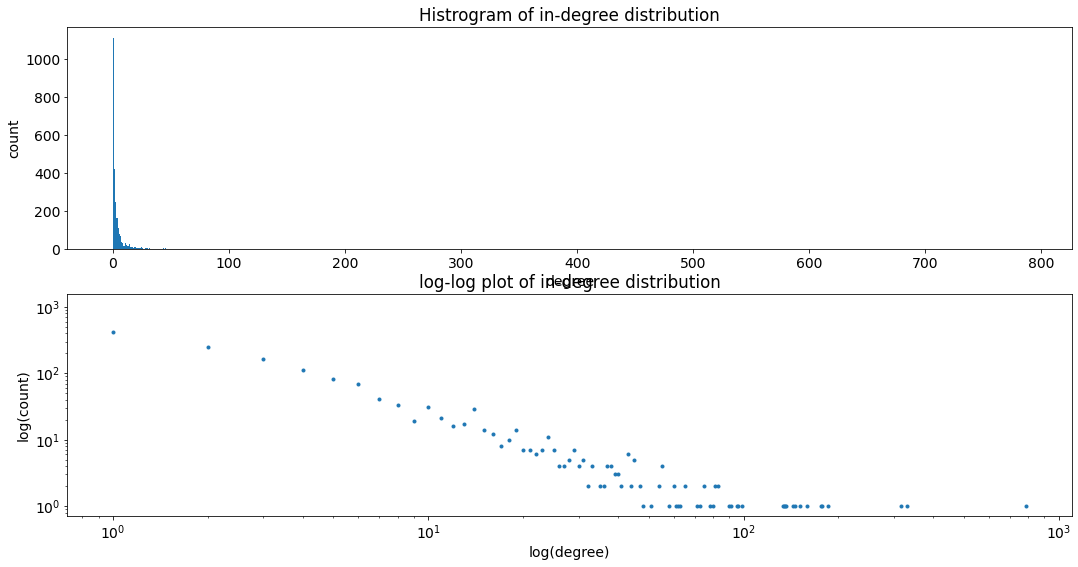

In [ ]:
from collections import Counter 
# change fig size
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 9) 
plt.rcParams.update({'font.size': 14}) 

plt.subplot(2,1,1)
plt.hist(degrees_in,bins=max(degrees_in)+1)
plt.xlabel('degree')
plt.ylabel('count')
plt.title('Histrogram of in-degree distribution')

c_in = Counter(degrees_in)
plt.subplot(2,1,2)
plt.loglog(list(c_in.keys()),list(c_in.values()),'.')
plt.xlabel('log(degree)')
plt.ylabel('log(count)')
plt.title('log-log plot of in-degree distribution')
plt.show()

We see that a lot of nodes has a very small degree and that few nodes has a high degree. 
The same can be seen in the logarithmic plot, were we have a high count for small degrees and lower counts for higher degrees. 
We investigate this further by plotting $p_k$ (probability of a node haven degree k). 
Included in this plot is also the theoretical distribution for a random and a scale free network. 
The degree distribution of a random network can be approximated by a poisson distibution when $\langle k\rangle << N$ - which is the case here. 
Thus eq.3.8 from [the book](http://networksciencebook.com/chapter/3#degree-distribution) is used:

$$p_k=\exp^{-\langle k\rangle}\frac{\langle k\rangle ^k}{k!}.$$

A scale-free network is a network whose degree distribution follows a power law. Thus using eq. 4.1 from [the book](http://networksciencebook.com/chapter/4#introduction4):

$$p_k=k^{-\gamma}.$$

Taken the logarithm on both sides yields that $\log p_k$ is expected to depend linearly on $\log k$. 
Here $\gamma$ is set to 2. Below the two theoretical distributions are greated and the degree-distribtion is converted to percent:

In [ ]:
# theoreticel degree dist. for random/poisson and scale free/power-low
k_ave_in = np.average(degrees_in)
gamma_in = 1.8

x_scale = range(min(degrees_in),math.floor(max(degrees_in)/4))
x_pois = range(min(degrees_in),math.floor(max(degrees_in)/20))
x_scale = x_scale[1:]
x_pois = x_pois[1:]
y_scale = [k**(-gamma_in) for k in x_scale]
y_pois = [math.exp(-k_ave_in) * k_ave_in**k / math.factorial(k) for k in x_pois]

# counts to percent
c_in = Counter(degrees_in)
c_in_percent = [ c_in[i] / len(degrees_in) for i in c_in]

Now the in-degree distribution can be plotted:

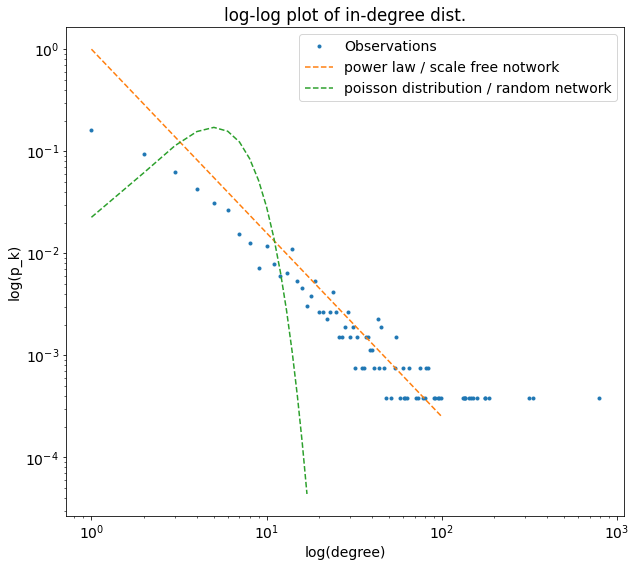

In [ ]:
# change fig size
plt.rcParams['figure.figsize'] = (10, 9) 
plt.rcParams.update({'font.size': 14}) 

# plot
#plt.subplot(1,2,1)
#plt.loglog(list(c_in.keys()),list(c_in.values()),'.', label = 'Observations')
#plt.xlabel('log(degree)')
#plt.ylabel('log(count)')
#plt.legend()
#plt.title('log-log plot of in-degree dist.')

#plt.subplot(1,2,2)
plt.loglog(list(c_in.keys()),c_in_percent,'.', label = 'Observations')
plt.loglog(x_scale[:100],y_scale[:100],'--', label = 'power law / scale free notwork')
plt.loglog(x_pois[:17],y_pois[:17],'--', label = 'poisson distribution / random network')
plt.xlabel('log(degree)')
plt.ylabel('log(p_k)')
plt.legend()
plt.title('log-log plot of in-degree dist.')
plt.savefig("llindegree.png")
plt.show()

We see that the in-degree distribution resembles that of a scale free network as expected. 

Next we do the same for the out-degree distribution.

##### Plot out-degree distribution

First we plot the degree destribution both as a histogram and as points in a log-log scale.

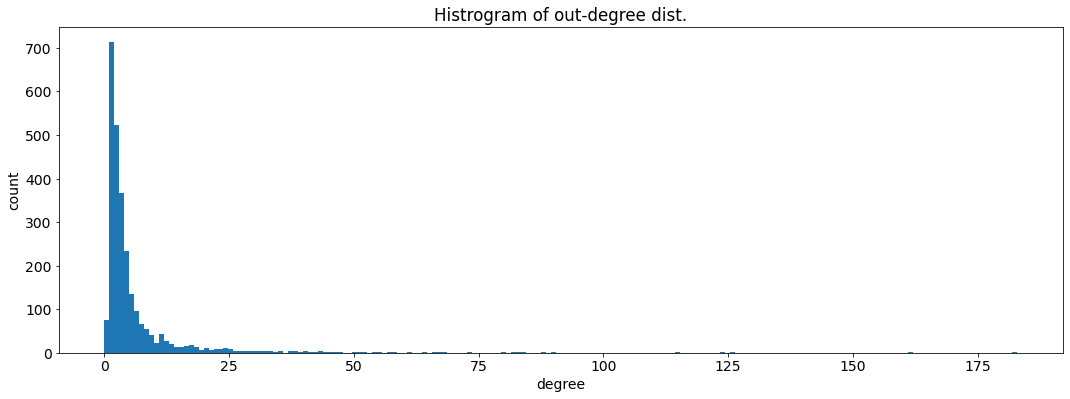

In [ ]:
plt.rcParams['figure.figsize'] = (18, 6) 
plt.rcParams.update({'font.size': 14}) 

plt.hist(degrees_out,bins=max(degrees_out)+1)
plt.xlabel('degree')
plt.ylabel('count')
plt.title('Histrogram of out-degree dist.')
plt.savefig("histoutdegree.png")
plt.show()


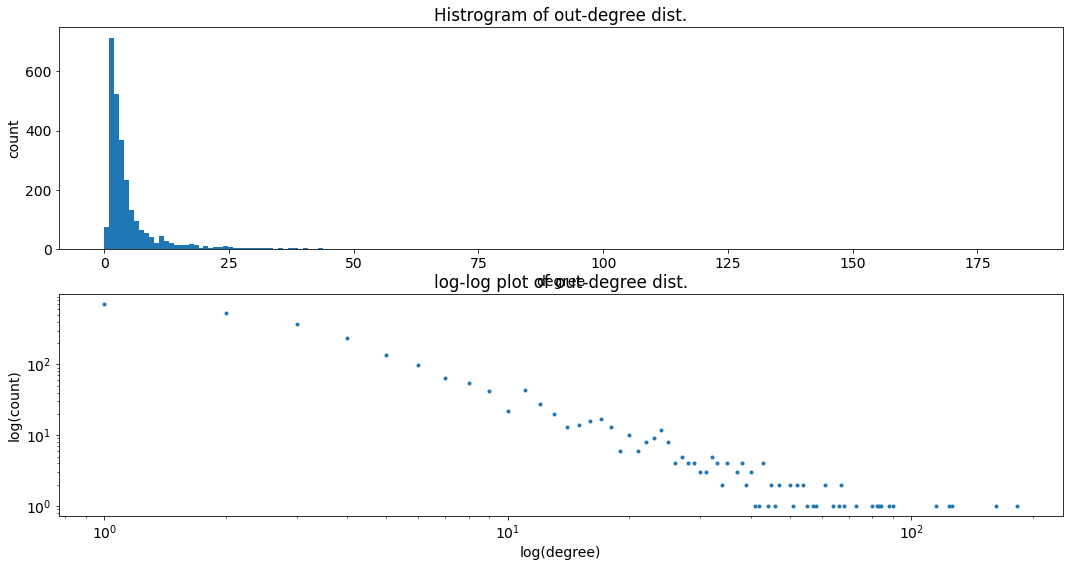

In [ ]:
# change fig size
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 9) 
plt.rcParams.update({'font.size': 14}) 

plt.subplot(2,1,1)
plt.hist(degrees_out,bins=max(degrees_out)+1)
plt.xlabel('degree')
plt.ylabel('count')
plt.title('Histrogram of out-degree dist.')

c_in = Counter(degrees_out)
plt.subplot(2,1,2)
plt.loglog(list(c_in.keys()),list(c_in.values()),'.')
plt.xlabel('log(degree)')
plt.ylabel('log(count)')
plt.title('log-log plot of out-degree dist.')
plt.show()

We see that fewer characters have zero outgoing edges compared to the number of characters having zero ingoing edges. 
This makes sense, since many characters link to the main person in their universe, e.g. many characters from the Harry Potter universe linking to Harry Potter. 
From the loglog plot we suspect a scale free network.

As the in-degree distribution, the out-degree destribution is compared to both the scale free network and the random network.

In [ ]:
# theoreticel degree dist. for random/poisson and scale free/power-low
k_ave_out = np.average(degrees_out)
gamma_out = 2

x_scale = range(min(degrees_out),math.floor(max(degrees_out)))
x_pois = range(min(degrees_out),math.floor(max(degrees_out)/2.8))
x_scale = x_scale[1:]
x_pois = x_pois[1:]
y_scale = [k**(-gamma_out) for k in x_scale]
y_pois = [math.exp(-k_ave_out) * k_ave_out**k / math.factorial(k) for k in x_pois]

# count to percent
c_out = Counter(degrees_out)
c_out_percent = [ c_out[i] / len(degrees_in) for i in c_out]

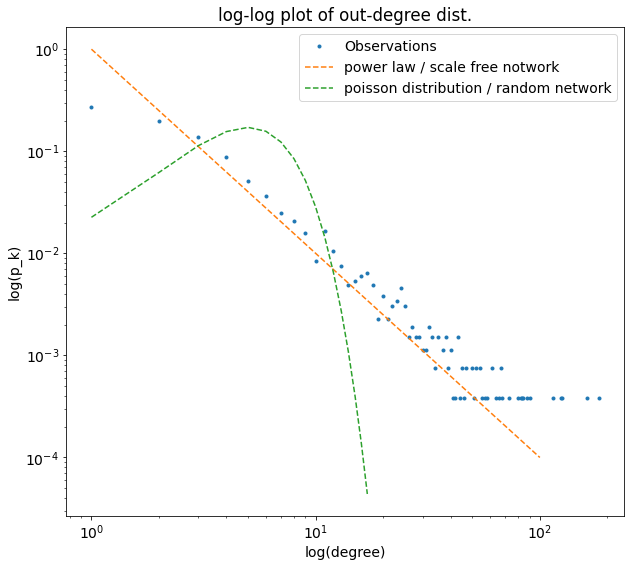

In [ ]:
# change fig size
plt.rcParams['figure.figsize'] = (10, 9) 
plt.rcParams.update({'font.size': 14}) 

# plot
#plt.subplot(1,2,1)
#plt.loglog(list(c_out.keys()),list(c_out.values()),'.')
#plt.xlabel('log(degree)')
#plt.ylabel('log(count)')
#plt.title('log-log plot of in-degree dist.')

#plt.subplot(1,2,2)
plt.loglog(list(c_out.keys()),c_out_percent,'.', label = 'Observations')
plt.loglog(x_scale[:100],y_scale[:100],'--', label = 'power law / scale free notwork')
plt.loglog(x_pois[:17],y_pois[:17],'--', label = 'poisson distribution / random network')
plt.xlabel('log(degree)')
plt.ylabel('log(p_k)')
plt.legend()
plt.title('log-log plot of out-degree dist.')
plt.savefig("lloutdegree.png")
plt.show()

Again, we see that the degree distribution resembles that of a scale free network more than that of a random network. 

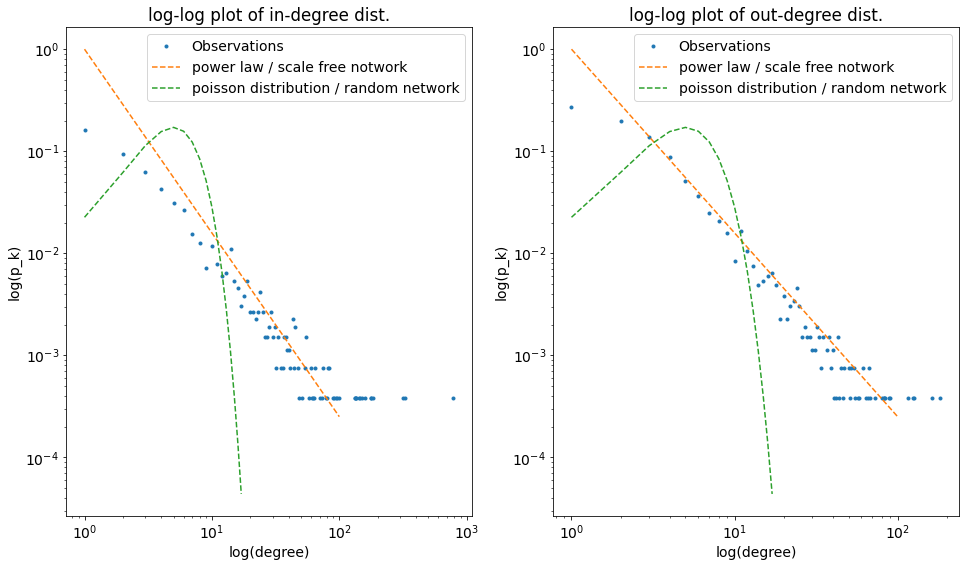

In [ ]:
# change fig size
plt.rcParams['figure.figsize'] = (16, 9) 
plt.rcParams.update({'font.size': 14}) 

plt.subplot(1,2,1)
plt.loglog(list(c_in.keys()),c_in_percent,'.', label = 'Observations')
plt.loglog(x_scale[:100],y_scale[:100],'--', label = 'power law / scale free notwork')
plt.loglog(x_pois[:17],y_pois[:17],'--', label = 'poisson distribution / random network')
plt.xlabel('log(degree)')
plt.ylabel('log(p_k)')
plt.legend()
plt.title('log-log plot of in-degree dist.')

plt.subplot(1,2,2)
plt.loglog(list(c_out.keys()),c_out_percent,'.', label = 'Observations')
plt.loglog(x_scale[:100],y_scale[:100],'--', label = 'power law / scale free notwork')
plt.loglog(x_pois[:17],y_pois[:17],'--', label = 'poisson distribution / random network')
plt.xlabel('log(degree)')
plt.ylabel('log(p_k)')
plt.legend()
plt.title('log-log plot of out-degree dist.')
plt.savefig("llinoutdegree.png")
plt.show()

##### Discussion
After doing an analysis og the degree distribution of our network, we can conclude that the degree distribution follows that of a 
scale-free network more than that of a random network. This was shown both by considering the theoretical range of a random network and illustrated by plots.
Many of the degrees fell outside the range and it must be concluded that the range is unbounded like for a scale free network. 
All plots indicated that the degree distributions resembled a power low destribution which approximates the degree distribution of a scale free network.

Linking this to our Harry Potter universe, this tells us that we have fewer nodes that are links to and from often while we have many nodes that are linked to and from very little.
This makes sense, since many of the unimportant characters have a connection to the few important characters. 

### 3.2 The Houses

On Hogwarts, the school is separated into four houses: Gryffindor, Hufflepuff, Rawenclaw and Slytherin. In the books and films, 
it is obvious that the house you end up in says a lot about who you befriend and spend a lot of time with. 
The separation between Gryffindor and Slytherin is special -  Gryffindor as the 'good' house and Slytherin as the 'evil' house.
It is therefore interesting to see if this separation is transparent in the network as well. To investigate this, 
we will consider the number of links within each house and compare this to the number of links between the houses. 
If we see more links within the houses than between the houses, we can argue for a separation between the houses. 
This meaning that characters wiki pages is more connected (link more) to characters from the same house than chracters from different houses. XXX

In [ ]:
#A graph of the network is created in the same fasion as in section 2.1. Here the above mentioned attributes are are added to each node as an attribute.
G_fandom2 = nx.DiGraph()
for i  in range(len(HP_fandom)): 
    G_fandom2.add_node(HP_fandom.CharacterName[i],  loyalty = HP_fandom.loyalty[i],
    blood = HP_fandom.blood[i], species = HP_fandom.species[i], gender = HP_fandom.gender[i],
    house = HP_fandom.house[i])
for i in range(len(HP_fandom)):
    links = HP_fandom.Links[i]
    for j in range(len(links)):
        G_fandom2.add_edges_from([(HP_fandom.CharacterName[i],links[j])])

To do this, we will only consider a subgraph consisting of all the nodes that belong to the four houses at Hogwarts.

In [ ]:
nodes_houses = (
    node
    for node, data
    in G_fandom.nodes(data=True)
    if data.get("house") == 'gryffindor' 
    or data.get("house") == 'hufflepuff'
    or data.get("house") == 'ravenclaw'
    or data.get("house") == 'slytherin'
)
G_houses = G_fandom.subgraph(nodes_houses)

In [ ]:
G_houses_dcc = G_houses.copy()
G_houses_dcc.remove_nodes_from(list(nx.isolates(G_houses_dcc)))
nx.write_gpickle(G_houses_dcc, "G_houses_dcc.gpickle")
#G_houses_dcc = [G_houses.subgraph(c).copy() for c in nx.weakly_connected_components(G_houses)]
#G_houses_dcc = G_houses_dcc[0]

In [ ]:
# number of nodes and edges
G_houses_nodes = G_houses_dcc.number_of_nodes()
G_houses_edges = G_houses_dcc.number_of_edges()
print('The graph now has {} nodes and {} edges.'.format(G_houses_nodes,G_houses_edges))

The graph now has 510 nodes and 3792 edges.


We are interested in the number of links between the houses and within the different houses. These are found below.

In [ ]:
house_matrix = nx.attr_matrix(G_houses, node_attr='house')

As we have 4 different houses, we have $4^2=16$ different kind of links. Thus we illustrate them in a heatmap.

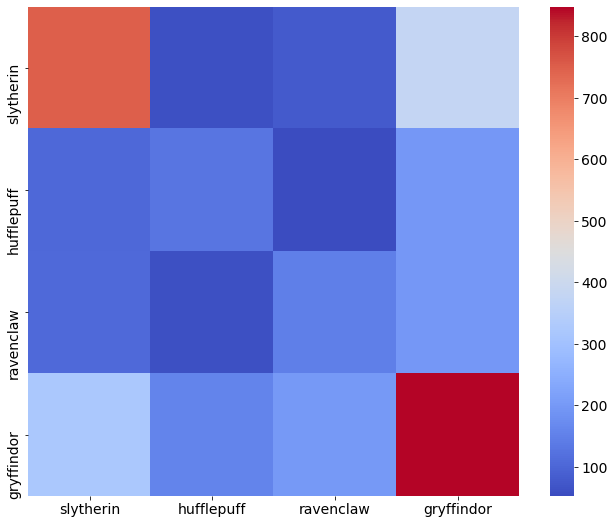

In [ ]:
# change fig size
plt.rcParams['figure.figsize'] = (11, 9) 
plt.rcParams.update({'font.size': 14}) 

sns.heatmap(house_matrix[0], xticklabels = house_matrix[1], yticklabels = house_matrix[1], cmap='coolwarm')#,annot=True)
plt.savefig("heat_houses.png")

We see that links within the Gryffindor house has the highest count and links within Slytherin has the second highest count. 
Let's check the number of characters within each house. XXX

In [ ]:
houses_count = dict(list(G_houses_dcc.nodes(data='house'))).values()
house_name = list(Counter(houses_count).keys())
heat_nodes = list(Counter(houses_count).values())
print('Number of characters in:\n - {}: \t{}\n - {}: \t{}\n - {}: \t{}\n - {}: \t{}\n'.format(house_name[0],heat_nodes[0],house_name[1],heat_nodes[1],house_name[2],heat_nodes[2],house_name[3],heat_nodes[3]))

Number of characters in:
 - gryffindor: 	155
 - ravenclaw: 	95
 - hufflepuff: 	97
 - slytherin: 	163



And let's consider the number of outgoing edges for each house

In [ ]:
heat_edges = house_matrix[0].sum(axis = 1)
print('Number of outgoing edges for:\n - {}: \t{}\n - {}: \t{}\n - {}: \t{}\n - {}: \t{}\n'.format(house_matrix[1][0],int(heat_edges[0,0]),house_matrix[1][1],int(heat_edges[1,0]),house_matrix[1][2],int(heat_edges[2,0]),house_matrix[1][3],int(heat_edges[3,0])))

Number of outgoing edges for:
 - slytherin: 	1270
 - hufflepuff: 	483
 - ravenclaw: 	513
 - gryffindor: 	1526



And the number of ingoing edges for each house

In [ ]:
heat_edges = house_matrix[0].sum(axis = 0)
print('Number of ingoing edges for:\n - {}: \t{}\n - {}: \t{}\n - {}: \t{}\n - {}: \t{}\n'.format(house_matrix[1][0],int(heat_edges[0,0]),house_matrix[1][1],int(heat_edges[0,1]),house_matrix[1][2],int(heat_edges[0,2]),house_matrix[1][3],int(heat_edges[0,3])))

Number of ingoing edges for:
 - slytherin: 	1283
 - hufflepuff: 	411
 - ravenclaw: 	477
 - gryffindor: 	1621



Most of the characters belong to the house of Gryffindor and Slytherin and they have more than twice as many outgoing edges as Hufflepuff and Ravenclaw respectively. The
above heatmap is not representative. Thus we norm the number of characters in each house and create a new heatmap. XXX

In [ ]:
house_matrix_norm = nx.attr_matrix(G_houses, node_attr='house', normalized=True)

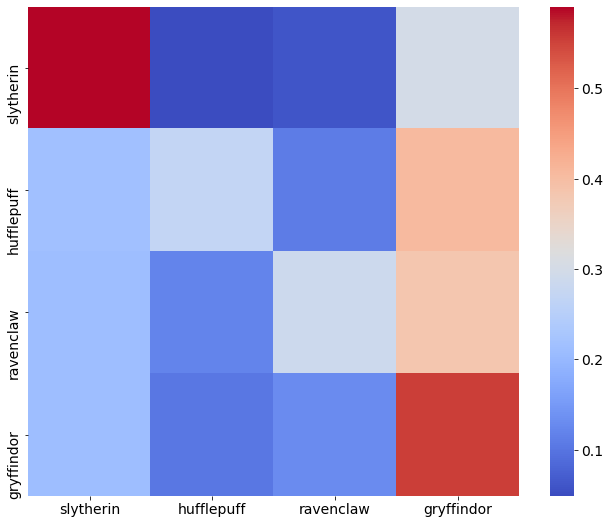

In [ ]:
sns.heatmap(house_matrix_norm[0], xticklabels = house_matrix_norm[1], yticklabels = house_matrix_norm[1], cmap='coolwarm')
plt.savefig("heat_houses_per.png")

We see that Gryffindor characters link most to characters from their own house. The same is the case for the Slytherin house. 
But characters from both Rawenclaw and Hufflepuff links mostly to characters in Gryffindor. 
An explanation could be that Gryffindor and Slytherin is both big/important houses with important characters 
whereas Ravenclaw and Hufflepuff mostly consists of smaller/less important characters - thus characters are not linked to these.

Lastly, the network of the subgraph of houses is illustrated below.

First the giant component is defined.

In [ ]:
G_houses_dcc1 = [G_houses.subgraph(c).copy() for c in nx.weakly_connected_components(G_houses)]
G_houses_dcc1 = G_houses_dcc1[0]
nx.write_gpickle(G_houses_dcc1, "G_houses_dcc1.gpickle")

Then the dataframe only contaning characters in the four houses is made.

In [ ]:
#find characters not in hog
not_in = list(set(list(HP_fandom_dcc["CharacterName"])) - set(list(G_houses_dcc.nodes())))          
#Create community dataframe
HP_houses_dcc = HP_fandom_dcc[~HP_fandom_dcc["CharacterName"].isin(not_in)].reset_index(drop=True)

#Find links 
for i in range(len(HP_houses_dcc)):
    match = re.findall(r'\[\[(?:[^|\]]*\|)?([^\]]+)\]\]', str(HP_houses_dcc.WikiText[i]))
    match = set(match).intersection(set(HP_houses_dcc['CharacterName'].unique()))
    HP_houses_dcc.Links[i] = list(match)

#save dataframe to load later
pickle.dump(HP_houses_dcc , open( "HP_houses_dcc.p", "wb" ) )

/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



The edges are added with weight, reflecting if the pair is in the same house or not. 

In [ ]:
# add edges 
for i in range(len(HP_houses_dcc)):
    links = HP_houses_dcc.Links[i]
    for j in range(len(links)):
        if (HP_houses_dcc.house[HP_houses_dcc.CharacterName == links[j]] == HP_houses_dcc.house[i]).item():
            G_houses_dcc.add_edges_from([(HP_houses_dcc.CharacterName[i],links[j])], weight = 20)
        elif (HP_houses_dcc.house[HP_houses_dcc.CharacterName == links[j]] != HP_houses_dcc.house[i]).item():
                G_houses_dcc.add_edges_from([(HP_houses_dcc.CharacterName[i],links[j])], weight = 5)

G_houses_un = G_houses_dcc.to_undirected()
nx.write_gpickle(G_houses_un, "G_houses_un.gpickle")

And the details for the function is defined.

In [ ]:
positions = forceatlas2.forceatlas2_networkx_layout(G_houses_un, pos=None, iterations=4000, weight_attr='weight')
d = dict(nx.degree(G_houses_un))
n = list(d.keys())
v = list(d.values())
linkList = ['House: ' + l for l in nx.get_node_attributes(G_houses_un,'house').values()]
nameList = ['Name: ' + n for n in list(G_houses_un.nodes())]
hoverList = [nameList[i] + '<br>' + linkList[i] for i in range(len(linkList))]
nc = list(nx.get_node_attributes(G_houses_un,'house').values())
for i in range(len(nc)):
    if nc[i] == 'gryffindor':
        nc[i] = 'red'
    elif nc[i] == 'ravenclaw':
        nc[i] = 'blue'
    elif nc[i] == 'hufflepuff':
        nc[i] = 'yellow'
    elif nc[i] == 'slytherin':
        nc[i] = 'green'

100%|██████████| 4000/4000 [00:22<00:00, 180.20it/s]BarnesHut Approximation  took  6.17  seconds
Repulsion forces  took  13.91  seconds
Gravitational forces  took  0.14  seconds
Attraction forces  took  0.29  seconds
AdjustSpeedAndApplyForces step  took  0.65  seconds



In [ ]:
intergraph(G_houses_un, positions, ['darkgreen', 0.7, 0.5], [4], hoverList, nc, 'Houses in Harry Potter fandom universe')	

##### Discussion
All in all, we saw a separation between especially the Gryffindor house and the Slytherin house, where each house linked more to its own house than to the other three houses respectively. 
They also linked second most to each other. If we consider the Ravenclaw and the Hufflepuff house, they linked mostly to the Gryffindor house and second most to themselves.
It is interesting that they link second must to themselfs and not second most to Slytherin. This shows that Gryffindor is a bigger or more important house than Slytherin.
It is also noted that the distance in how much Gryffindor links to Slytherin compared to Ravenclaw and Hufflepuff is not at big as 
the distance in how much Slytherin links to Gryffindor compared to Ravenclaw and Hufflepuff. 
Meaning that Slytherin do not link very much to Ravenclaw and Hufflepuff compared to Gryffindor. XXX
This again underlines that Gryffindor is the house everything centers about with Slytheren being the second biggest.

### 3.3 Blood

From the preliminary analysis we also considered the different blod types that characters could have. We are especially interested in these four:

In [ ]:
blood.sort_values(ascending = False)[0:4]

blood
pure-blood          391
non-magic people    298
half-blood           88
muggle-born          25
Name: CharacterName, dtype: int64

In the Harry Potter books/movies, Voldemort (the evil guy) is out to kill all muggle-borns (wizards with non-magic parents) - also known as mudbloods! 
Thus the books exploit the separation of pure-blood, half-bood, muggle-born and of course non-magic people. 
It is therefore interesting to see if we see the same separation in the network. 
First we create a subgraph consisting only of characters from the above four groups.

In [ ]:
nodes_blood = (
    node
    for node, data
    in G_fandom.nodes(data=True)
    if data.get("blood") == 'pure-blood' 
    or data.get("blood") == 'non-magic people'
    or data.get("blood") == 'half-blood'
    or data.get("blood") == 'muggle-born'
)
G_blood = G_fandom.subgraph(nodes_blood)

We exclude the nodes with no edges.

In [ ]:
G_blood_dcc = G_blood.copy()
G_blood_dcc.remove_nodes_from(list(nx.isolates(G_blood_dcc)))
nx.write_gpickle(G_blood_dcc, "G_blood_dcc.gpickle")

In [ ]:
# number of nodes and edges
G_blood_nodes = G_blood_dcc.number_of_nodes()
G_blood_edges = G_blood_dcc.number_of_edges()
print('The graph now has {} nodes and {} edges.'.format(G_blood_nodes,G_blood_edges))

The graph now has 654 nodes and 5539 edges.


As with the houses, we will consider the number of links within each blood type and compare to the number of links between the bood types.

In [ ]:
blood_matrix = nx.attr_matrix(G_blood_dcc, node_attr='blood')

Again we have $4^2=16$ combinations so we illustrate it in a heatmap.

<AxesSubplot:>

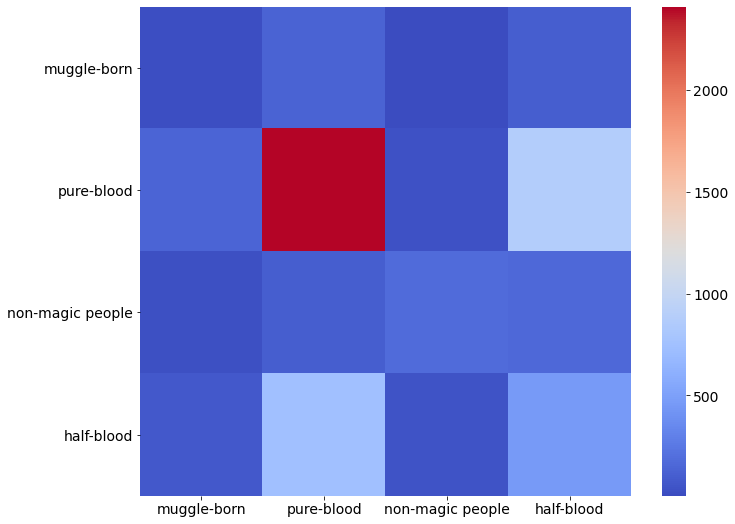

In [ ]:
# change fig size
plt.rcParams['figure.figsize'] = (11, 9) 
plt.rcParams.update({'font.size': 14}) 

sns.heatmap(blood_matrix[0], xticklabels = blood_matrix[1], yticklabels = blood_matrix[1], cmap='coolwarm')

We see most links between pure-blood characters. But how many pure-blood characters do we have in the network?

In [ ]:
blood_count = dict(list(G_blood_dcc.nodes(data='blood'))).values()
blood_name = list(Counter(blood_count).keys())
heat_nodes = list(Counter(blood_count).values())
print('Number of characters in:\n - {}: \t{}\n - {}: \t\t{}\n - {}: \t\t{}\n - {}: \t{}\n'.format(blood_name[0],heat_nodes[0],blood_name[1],heat_nodes[1],blood_name[2],heat_nodes[2],blood_name[3],heat_nodes[3]))

Number of characters in:
 - pure-blood: 	363
 - non-magic people: 		185
 - muggle-born: 		23
 - half-blood: 	83



We see that we have most pure-blood characters. Next we consider the number of outgoing edges per blood type

In [ ]:
heat_edges = blood_matrix[0].sum(axis = 1)
print('Number of outgoing edges for:\n - {}: \t{}\n - {}: \t\t{}\n - {}: \t\t{}\n - {}: \t{}\n'.format(blood_matrix[1][0],int(heat_edges[0,0]),blood_matrix[1][1],int(heat_edges[1,0]),blood_matrix[1][2],int(heat_edges[2,0]),blood_matrix[1][3],int(heat_edges[3,0])))

Number of outgoing edges for:
 - muggle-born: 	261
 - pure-blood: 		3475
 - non-magic people: 		479
 - half-blood: 	1324



And the number of ingoing edges per blood type

In [ ]:
heat_edges = blood_matrix[0].sum(axis = 0)
print('Number of ingoing edges for:\n - {}: \t{}\n - {}: \t\t{}\n - {}: \t\t{}\n - {}: \t{}\n'.format(blood_matrix[1][0],int(heat_edges[0,0]),blood_matrix[1][1],int(heat_edges[0,1]),blood_matrix[1][2],int(heat_edges[0,2]),blood_matrix[1][3],int(heat_edges[0,3])))

Number of ingoing edges for:
 - muggle-born: 	276
 - pure-blood: 		3391
 - non-magic people: 		270
 - half-blood: 	1602



We see that the pure-bloods are highly overrepresented, both in number of nodes, number of outgoing edges and number of ingoing edges. 
Another interesting thing is that non-magic poeple has many nodes represented in the graph but they have few in- and outgoing edges.
On the other hand, there are not that many half-bloods but we see a lot of in- and outgoing edges for the half-bloods. 
An explanation to this is that not many non-magic people has important roles in Harry Potter compared to half-blood characters. 
We norm by the blood-races and create a new heatmap.

In [ ]:
blood_matrix_norm = nx.attr_matrix(G_blood, node_attr='blood', normalized=True)

<AxesSubplot:>

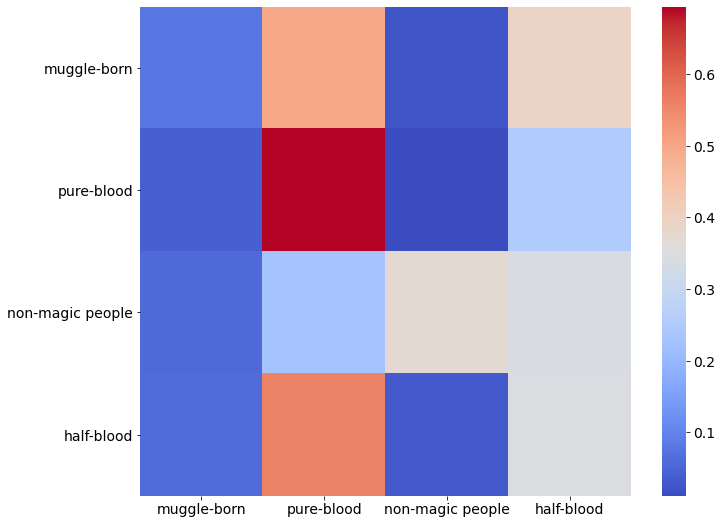

In [ ]:
sns.heatmap(blood_matrix_norm[0], xticklabels = blood_matrix_norm[1], yticklabels = blood_matrix_norm[1], cmap='coolwarm')

We see that pure-bloods, half-bloods and muggle-borns all link most to pure-bloods where non-magic people link mostly to other non-magic people. 
All four group link second most to half-bloods. In general, not many characters link to non-magic people and muggle-born. 

A picture for the webage is saved.

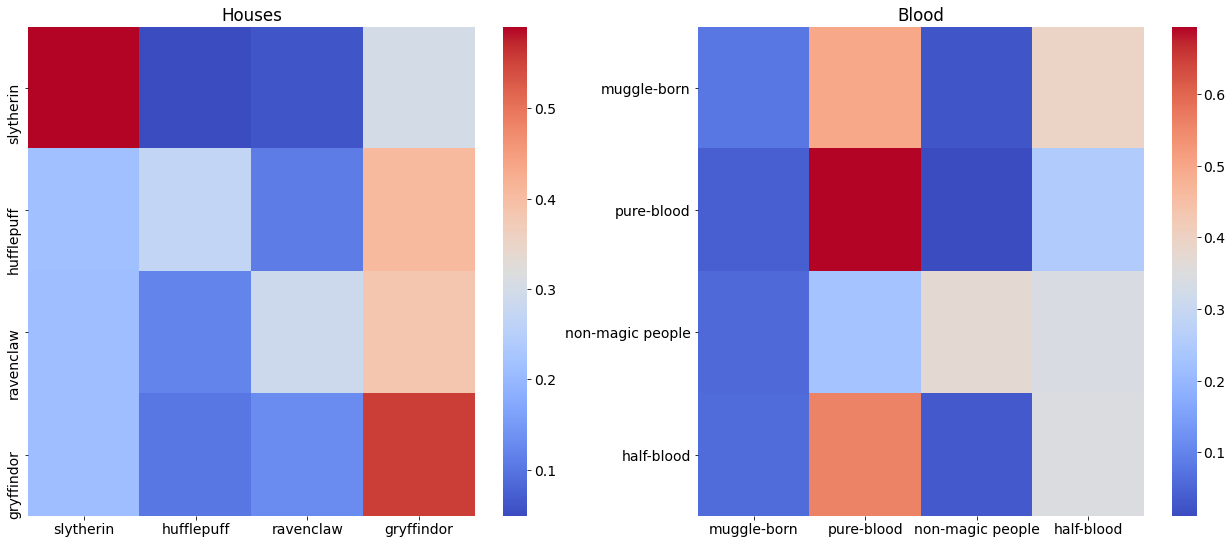

In [ ]:
plt.rcParams['figure.figsize'] = (22, 9) 
plt.rcParams.update({'font.size': 14})
plt.subplot(1,2,1)
sns.heatmap(house_matrix_norm[0], xticklabels = house_matrix_norm[1], yticklabels = house_matrix_norm[1], cmap='coolwarm')
plt.title('Houses')
plt.subplot(1,2,2)
sns.heatmap(blood_matrix_norm[0], xticklabels = blood_matrix_norm[1], yticklabels = blood_matrix_norm[1], cmap='coolwarm')
plt.title('Blood')
plt.savefig("heat_houses_blood.png")

##### Discussion
All in all, we do not see as pronounced differences as for the houses in the previous section. 
We see that half-bloods, muggle-borns and pure-bloods link mostly to pure-bloods.
All three also link second most to half-bloods. On the other hand, non-magic people link mostly to non-magic people and second most to half-bloods. 
Thus we might see a separation between non-magic people and magic people in general. 
This makes sense, since in the book we also a clear separation of the non-magic people and the magic people. 
Thus even though the general purpose for the evil guy (Voldemort) is to separate pure-bloods and muggle-borns (partly also half-bloods), 
we do not see this difference in the wikipages of the characters. 

In [14]:
#G_blood_dcc1 = [G_blood_dcc.subgraph(c).copy() for c in nx.weakly_connected_components(G_blood_dcc)]
#G_blood_dcc1 = G_blood_dcc1[0]
#nx.write_gpickle(G_blood_dcc1, "G_blood_dcc1.gpickle")
G_blood_dcc1 = nx.read_gpickle("G_blood_dcc1.gpickle")
#find characters not in hog
#not_in = list(set(list(HP_fandom_dcc["CharacterName"])) - set(list(G_blood_dcc1.nodes())))          
#Create community dataframe
#HP_blood_dcc = HP_fandom_dcc[~HP_fandom_dcc["CharacterName"].isin(not_in)].reset_index(drop=True)
HP_blood_dcc = pickle.load(open( "HP_blood_dcc.p", "rb" ))
#Find links 
#for i in range(len(HP_blood_dcc)):
#    match = re.findall(r'\[\[(?:[^|\]]*\|)?([^\]]+)\]\]', str(HP_blood_dcc.WikiText[i]))
#    match = set(match).intersection(set(HP_blood_dcc['CharacterName'].unique()))
#    HP_blood_dcc.Links[i] = list(match)

#save dataframe to load later
#pickle.dump(HP_blood_dcc , open( "HP_blood_dcc.p", "wb" ) )

# add edges 
for i in range(len(HP_blood_dcc)):
    links = HP_blood_dcc.Links[i]
    for j in range(len(links)):
        if (HP_blood_dcc.house[HP_blood_dcc.CharacterName == links[j]] == HP_blood_dcc.blood[i]).item():
            G_blood_dcc1.add_edges_from([(HP_blood_dcc.CharacterName[i],links[j])], weight = 20)
        elif (HP_blood_dcc.house[HP_blood_dcc.CharacterName == links[j]] != HP_blood_dcc.blood[i]).item():
                G_blood_dcc1.add_edges_from([(HP_blood_dcc.CharacterName[i],links[j])], weight = 5)

G_blood_dcc2 = [G_blood_dcc1.subgraph(c).copy() for c in nx.weakly_connected_components(G_blood_dcc1)]
G_blood_dcc2 = G_blood_dcc2[0]
G_blood_un = G_blood_dcc2.to_undirected()
nx.write_gpickle(G_blood_un, "G_blood_un.gpickle")

positions = forceatlas2.forceatlas2_networkx_layout(G_blood_un, pos=None, iterations=4000, weight_attr='weight')
d = dict(nx.degree(G_blood_un))
n = list(d.keys())
v = list(d.values())
linkList = ['House: ' + l for l in nx.get_node_attributes(G_blood_un,'blood').values()]
nameList = ['Name: ' + n for n in list(G_blood_un.nodes())]
hoverList = [nameList[i] + '<br>' + linkList[i] for i in range(len(linkList))]
nc = list(nx.get_node_attributes(G_blood_un,'blood').values())
for i in range(len(nc)):
    if nc[i] == 'half-blood':
        nc[i] = 1
    elif nc[i] == 'non-magic people':
        nc[i] = 2
    elif nc[i] == 'pure-blood':
        nc[i] = 3
    elif nc[i] == 'muggle-born':
        nc[i] = 4

intergraph(G_blood_un, positions, ['grey', 0.7, 0.5], [4], hoverList, nc, 'Bloodtype in Harry Potter fandom universe', 'Reds')	

100%|██████████| 4000/4000 [00:17<00:00, 231.63it/s]
BarnesHut Approximation  took  5.34  seconds
Repulsion forces  took  10.48  seconds
Gravitational forces  took  0.10  seconds
Attraction forces  took  0.25  seconds
AdjustSpeedAndApplyForces step  took  0.50  seconds


### 3.4 Communities

As we have seen, the Harry Potter universe has a large amount of characters.
Reading the books and seeing the movies, many clear connections between the characters are unavoidable, but are these connections the most obvious when looking into the fandom wiki pages or are there hidden connections that we do not catch when reading the books and seeing the movies?
The connections between characters can be explored using algorithms that forms communities in the network. Communities are smaller locally dense connected subgraphs in a network, where the nodes are more likely to connect to other nodes in the same community ([Network science](http://networksciencebook.com/chapter/9)). 
It is interesting to look at these communities to see if e.g. families will forms networks together, or enemies have a stronger connection than friendships and familiy. It is also interesting to see if the above analysis of the houses and blood types also play a role when looking at networks.


Using the built-in Louvain algorithm, [which maximises the modularity (or try..) using the Louvain heuristices](https://python-louvain.readthedocs.io/en/latest/api.html), the communities will be formed and we will be able to investigate patterns in these communities.

We start by forming the networks.

In [ ]:
#Fandom
#Compute the best partition
#import community
#from community import community_louvain
#Do not run, use the pickled 
partition_fandom = community.best_partition(G_fandom_un)
#Number of comminities
N_fandom = max(partition_fandom.values())+1

#save partitions to load later
pickle.dump(partition_fandom , open( "partition_fandom.pickle", "wb" ) )

The number of communities are calculated.

In [ ]:
# Number of communities
print('The Louvain algorithm found {} communities in the fandom graph.'.format(N_fandom))

The Louvain algorithm found 25 communities in the fandom graph.


The size of each community is found and a barplot showing the sizes is made.

In [ ]:
# Count the size of communities
com_fandom = Counter(list(partition_fandom.values())).most_common()

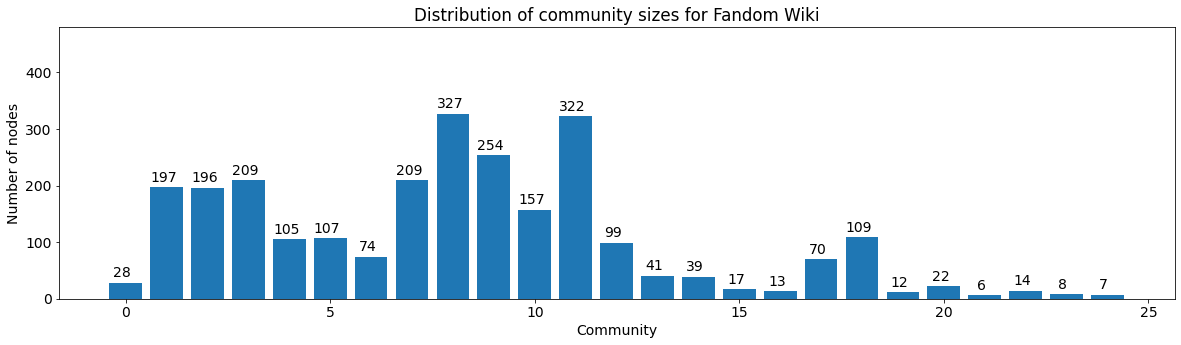

In [ ]:
# Plot distribution of community size
comSize_fandom = []
comNum_fandom = []

for i in com_fandom:
    comSize_fandom.append(i[1])
    comNum_fandom.append(i[0])

fig = plt.figure(figsize=(20,5))

plt.bar(comNum_fandom, comSize_fandom)
for i,j in zip(comNum_fandom,comSize_fandom):
    if j > 99:
        plt.text(x = i-0.4, y = j+10, s = str(j))
    elif j > 9:
        plt.text(x = i-0.3, y = j+10, s = str(j))
    else:
        plt.text(x = i-0.2, y = j+10, s = str(j))
plt.ylim(0,480)
plt.title("Distribution of community sizes for Fandom Wiki")
plt.xlabel("Community")
plt.ylabel("Number of nodes")
plt.savefig("com_dist.png")
plt.show()

As can be seen there are some communities that are quite small. These probably consist of minor characters.
The first characters of the small community 16 and the large community 1 are printed to see if this assumption is correct. 

In [ ]:
com0 = []
com1 = []
for k, v in partition_fandom.items():
    if v == 16:
        com0.append(k)
    if v == 1:
        com1.append(k)
    
print("Characters in community 16: ")
print(com0[0:5])
print("Characters in community 1: ")
print(com1[0:5])

Characters in community 16: 
['Celestina Warbeck', 'Ignatia Wildsmith', "Lorcan d'Eath", 'Devlin Whitehorn', 'Derwent Shimpling']
Characters in community 1: 
['Bartemius Crouch Junior', 'Alphard Black', 'Iola Black', 'Phineas Black', 'Sirius Black']


Comparing these communities, the pattern that we expected is shown. All of the characters in the small community are minor characters, while we have major characters in the large community.
Thus we only consider the communities of more than 100 characters.

In [ ]:
#Find communities with more than 50 character
c = 0
for s in comSize_fandom:
    if s > 100:
        c = c +1 

print('There are {} communities with more than 100 characters.'.format(c))
# Find the largest communities
top = Counter(list(partition_fandom.values())).most_common(c)

There are 11 communities with more than 100 characters.


To get a deeper understanding of how the algorithm have seperated the graph into communities, it would be interesting to look at the
most connected characters in each of these. The most connected characters must be the ones defining the communities and thus these would be a good indication of how the characters are connected.
The 6 most connected characters of large communities are found below.

In [ ]:
#Find numbers of top communities
top_num = []
for i in range(len(top)):
    top_num.append(top[i][0])

In [ ]:
#Find degrees of each character in each community
com_dicts = []

for i in range(N_fandom):
    com_dict = {}
    for key in partition_fandom:
        if partition_fandom[key]== i:
            com_dict[key] = G_fandom_un.degree(key)
    com_dicts.append(com_dict)

In [ ]:
#Find names of three most connected
names6 = []
for community in com_dicts:
    name = list(nlargest(6, community, key = community.get))
    names6.append((", ").join(name))

In [ ]:
print("The 6 most connected characters in each community are:")
for j,i in zip(range(N_fandom),names6[0:N_fandom]):
    if j in top_num:
        print(' {}: {}'.format(j,i))

The 6 most connected characters in each community are:
 1: Sirius Black, Horace Slughorn, Bellatrix Lestrange, Nymphadora Tonks, Lucius Malfoy, Phineas Nigellus Black
 2: Ronald Weasley, Arthur Weasley, George Weasley, Molly Weasley, Remus Lupin, Ginevra Weasley
 3: Albus Dumbledore, Tom Riddle, Salazar Slytherin, Delphini, Aberforth Dumbledore, Beedle the Bard
 4: Miranda Goshawk, Merlin, Cadogan, Ivy Warrington, Daniel Page, Fay Dunbar
 5: Rubeus Hagrid, Tom, Buckbeak, Olympe Maxime, Walden Macnair, Amelia Bones
 7: Gellert Grindelwald, Nagini, Newton Scamander, Credence Barebone, Porpentina Goldstein, Jacob Kowalski
 8: Severus Snape, Draco Malfoy, Dolores Umbridge, Minerva McGonagall, Neville Longbottom, Cedric Diggory
 9: Jacob's sibling, Penny Haywood, Peeves, Patricia Rakepick, Barnaby Lee, Rowan Khanna
 10: Hermione Granger, Fenrir Greyback, Griphook, Corban Yaxley, Xenophilius Lovegood, Travers
 11: Harry Potter, Vernon Dursley, Dudley Dursley, Petunia Dursley, Hedwig, Arabell

The communities show some clear connections:

Community 2 is clearly containing most of the Weasley family. Remus Lupin does also appear in this community, but makes sense as they are connected due to events, such as being The Order of the Phoenix. 
The same goes for community 11 that is the Dursley family. Harry Potter also occurs in this as he is also a part of this family.
 Overall, many characters with the same surname or characters which are in the same family appear in the same communities (e.g. community 1, 11 and 18).

The fact that Rubeus Hagrid appears in the same communites as creatures such as Buckbeak, and with Olympe Maxime (the teacher from the French school in book 4), also makes sense, since he works with creatues and dates Olympe.

Community 1, 3, and 8 also have a lot of large characters. 

Community 8 is a "Hogwarts" community with some of the largest characters who are pupils or teachers at Hogwarts. 

Community 3 holds Albus Dumbledore and Tom Riddle (Voldemort), which is clearly the main characters in this network, while Beedle the Bard and Aberforth Dumbledore are also important characters mainly in the last book. 
These character have a clear connection to Albus and Voldemort. 

The characters in Community 1 are probably connected due to familiy connections (Bellatrix was born Black and Lucius Malfoy's wife is also originally a Black), 
but to some extend this community cloud could also be connecteed due to enemies.

Community 7 is mainly a "Fantastic Beasts and where to find them" community.


A network graph coloring the nodes with respect to the communites are made with the plotting function. The communities are inserted in the giant component dataframe.

In [ ]:
HP_fandom_dcc['community'] = None

comList = list(partition_fandom.values())
comC = list(partition_fandom.keys())

for i in range(len(comC)):
    for j in range(len(HP_fandom_dcc)):
        if comC[i] == HP_fandom_dcc.CharacterName[j]:
            HP_fandom_dcc.community[j] = comList[i]

In [ ]:
#save dataframe to load later
pickle.dump(HP_fandom_dcc , open( "HP_fandom_dcc_com.pickle", "wb" ) )

Then a graph only using the communities as attributes is made.

In [ ]:
# init graph
G_fandom_com = nx.DiGraph()
# add nodes
for i in range(len(HP_fandom_dcc)): 
    G_fandom_com.add_node(HP_fandom_dcc.CharacterName[i], community = HP_fandom_dcc.community[i])
# add edges 
for i in range(len(HP_fandom_dcc)):
    links = HP_fandom_dcc.Links[i]
    for j in range(len(links)):
        if (HP_fandom_dcc.community[HP_fandom_dcc.CharacterName == links[j]] == HP_fandom_dcc.community[i]).item():
            G_fandom_com.add_edges_from([(HP_fandom_dcc.CharacterName[i],links[j])], weight = 10)
        elif (HP_fandom_dcc.community[HP_fandom_dcc.CharacterName == links[j]] != HP_fandom_dcc.community[i]).item():
            G_fandom_com.add_edges_from([(HP_fandom_dcc.CharacterName[i],links[j])], weight = 1)


G_com_un = G_fandom_com.to_undirected()
nx.write_gpickle(G_fandom_com, 'G_fandom_com.gpickle')
nx.write_gpickle(G_com_un, 'G_com_un.gpickle')

The variables the function uses is then made. 

In [16]:
G_com_un = nx.read_gpickle("G_com_un.gpickle")
#Find positions of nodes
positions = forceatlas2.forceatlas2_networkx_layout(G_com_un, pos=None, iterations=2000, weight_attr = 'weight')
#layout = forceatlas2.forceatlas2_igraph_layout(iG, pos=None, iterations=2000, weight_attr='weight')
d = dict(nx.degree(G_com_un))
n = list(d.keys())
v = list(d.values())
#Hover information
linkList = ['Community: ' + str(l) for l in list(nx.get_node_attributes(G_com_un,'community').values())]
nameList = ['Name: ' + str(n) for n in list(G_com_un.nodes())]
hoverList = [nameList[i] + '<br>' + linkList[i] for i in range(len(linkList))]
#color information
nc = list(nx.get_node_attributes(G_com_un,'community').values())

100%|██████████| 2000/2000 [01:03<00:00, 31.29it/s]BarnesHut Approximation  took  30.26  seconds
Repulsion forces  took  30.59  seconds
Gravitational forces  took  0.20  seconds
Attraction forces  took  0.38  seconds
AdjustSpeedAndApplyForces step  took  1.07  seconds



Then the graph is plotted.

In [47]:
intergraph(G_com_un, positions, ['grey', 0.7, 0.5], [5], hoverList, nc, 'Communities in Harry Potter fandom universe', 'mygbm')	

##### Discussion
All in all, many of the communities which are obvious in the books and movies are also found by the algorithm. 
The communities are to a great extent connected in families. However, communities are also made up by which books/movies the characters appear in
or due to places (e.g. Hogwarts) or events, if the characters have lesser described familiy. 
The house or blood relations are not evident in the communities, at least not as the main reason for a community being connected. 
Some of the small communities could be connected in the light of these factors, but these are not investigated here. 

### 3.5 Natural language processing

Written material can be analyzed with natural language processing. In this section, this will be done by cleaning text, extracting the important snippets, making wordclouds and analyzing the sentiments.

#### 3.5.1 Wordclouds

Wordclouds are a good tool, when we want to investigate which terms and/or characters are mentioned most in the written material. 
Overall it is of course interesting to see which characters and terms that are used most, 
but also to compare the different sources - the character pages, the books and the movies.

In order to use the wordclouds, the texts have to be cleaned. Both normal stopwords (e.g. "and"), punctuation, and main-words in exactly these text will have to be removed to get the best analysis.

In [ ]:
#Define stop-words an so.
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
punct = ["''","``","r","'s","ref","/ref","the",'the','r', 'https']
pattern = r'''(?x)     # set flag to allow verbose regexps
    (?:[A-Z]\.)+       # abbreviations, e.g. U.S.A.
    | \w+(?:-\w+)*       # words with optional internal hyphens
    | \$?\d+(?:\.\d+)?%? # currency and percentages, e.g. $12.40, 82%
    | \.\.\.             # ellipsis
    | [][.,;"'?():-_`]   # these are separate tokens; includes ], [
    '''
main_words = ['theme', 'f.a.', 'fa', '\\n', '\n', 'infobox', 'image', 'file', 'quote', 'a', 'b', 'c', 'd', 'e', 'f',
 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '...', 'http', 
 'www', 'website', 'com' 'faq_view', 'id', 'org', 'gof', 'category', 'individual', 'individuals', 'reference', 'jpg']
inf_words = ['colour', 'eye', 'born','died','blood','marital','nationality','gborie','alias','title','signature','species','name','goff','gender',
'male', 'female','height', 'weight','hair','eyes','skin','family','romances','animagus','boggart','wand','patronus',
'job','house','loyalty']

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


We first want to compare the three sources of text;  i.e. the character pages from fandom, the books and the movies. We start with the character pages.

We start by making a new column in the fandom dataframe, where the "cleaned" text for each character is inserted.

In [ ]:
#Tokennize texts, take out stopwords and lowecase all words in lis
HP_fandom['TokenizeText'] = None

for i in range(len(HP_fandom)):
    tmp_txt = HP_fandom.WikiText[i].lower()
    tmp_list = nltk.regexp_tokenize(tmp_txt.split("wikitext",1)[1], pattern)
    HP_fandom.TokenizeText[i] = [word.lower() for word in tmp_list if word not in string.punctuation and
    word not in stop_words and word not in punct and word not in main_words and word not in inf_words]

/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
#save dataframe to load later
pickle.dump(HP_fandom , open( "HP_fandom_tokens.p", "wb" ) )

All the texts are combined in one list of words.

In [ ]:
#Combine text of all character pages
HP_fandom_tokens = []

for i in range(len(HP_fandom)):
    HP_fandom_tokens.append(HP_fandom["TokenizeText"][i])

#Flatten list
HP_fandom_tokens = [val for sublist in HP_fandom_tokens for val in sublist]

The frequency of each word is found and the list is combined to a string consisting of the number of each word found.

In [ ]:
#Making frequency lists for each universe
HP_fandom_counts = nltk.FreqDist(HP_fandom_tokens)
HP_fandom_list = []

#Making list of words equal freq.
for key in HP_fandom_counts:
    val = math.ceil(HP_fandom_counts[key])
    HP_fandom_list.extend([key] * val)

#Transform list to text
HP_fandom_list = " ".join(HP_fandom_list)

Then the wordcloud can be made.

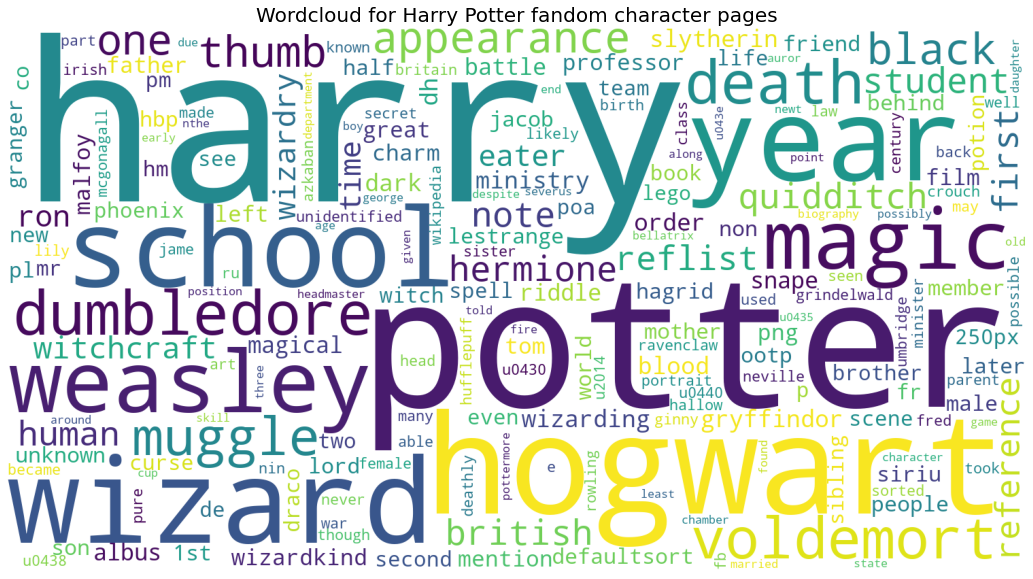

In [ ]:
#Make wordcloud
# change fig size
plt.rcParams['figure.figsize'] = (20, 10) 
plt.rcParams.update({'font.size': 14}) 

wordcloud = WordCloud(collocations = False, stopwords = None, background_color="white", width=1500, height=800).generate(HP_fandom_list)
img=plt.imshow(wordcloud)
plt.title("Wordcloud for Harry Potter fandom character pages", fontsize = 20)
plt.axis("off")
plt.show()

The most common words are as expected. 'Harry' is clearly the lagerst word. As seen in the interactive graph, Harry Potter was also one of the most connected characters.
'weasley' is more often used than the 'hermione' or 'granger', even though Ron and Hermione are both main characters. Seeing as Ron has a lot of siblings who also have a large role in the story, this makes sense. 
'ron' and 'hermione' are almost equally large, but are far smaller than both 'harry' and 'potter'. This indicates that Harry Potter is mentioned on more pages than the two others, and a reason for this could be that Harry has far more interactions with enemies and minor characters e.g. also in the computer games. 
Other characters such as 'Dumbledore' and 'Voldemort' are also mentioned a lot, and several surnames such as 'Black', 'Malfoy' and 'Lestrange' are also large.
Terms as 'hogwarts', 'school', 'wizard' and 'year' and words that have a connection to 'Hogwarts' and 'the wizarding world' are large. 'Death' is larger than 'eater', which indicates that 'death' is used in other connections than 'Death Eater'.

Some words relating to e.g. size of pictures, are also shown in the wordclouds. These could be removed by removing them from the texts.

#### 3.5.2 Books and movies

The same technique as used above is used for making the wordclouds of the books and movies. Each text has been tokenized seperately and afterwards inserted in a list holding all the tokens. 
As the script for the fifth movie is not available, this is omitited.

In [ ]:
#Books: Tokennize texts, take out stopwords and lowecase all words in lis
HP_books_tokens = []

for i in range(len(HP_books)):
    tmp_txt = HP_books[i].lower()
    tmp_list = nltk.regexp_tokenize(tmp_txt, pattern)
    HP_books_tokens.append([word.lower() for word in tmp_list if word not in string.punctuation and
    word not in stop_words and word not in punct and word not in main_words and word not in inf_words])

In [ ]:
#Movies: Tokennize texts, take out stopwords and lowecase all words in lis
HP_movies_tokens = []

for i in range(len(HP_movies)):
    if i != 4:
        tmp_txt = HP_movies[i].lower()
        tmp_list = nltk.regexp_tokenize(tmp_txt, pattern)
        HP_movies_tokens.append([word.lower() for word in tmp_list if word not in string.punctuation and
        word not in stop_words and word not in punct and word not in main_words and word not in inf_words])

Then all books and movies are combined to one text.

In [ ]:
#Book: combine tokens for all books
HP_books_tokensall = [val for sublist in HP_books_tokens for val in sublist]
HP_books_tokensall = " ".join(HP_books_tokensall)

In [ ]:
#Movies: combine tokens for all movies
HP_movies_tokensall = [val for sublist in HP_movies_tokens for val in sublist]
HP_movies_tokensall = " ".join(HP_movies_tokensall)

And the wordclouds are made.

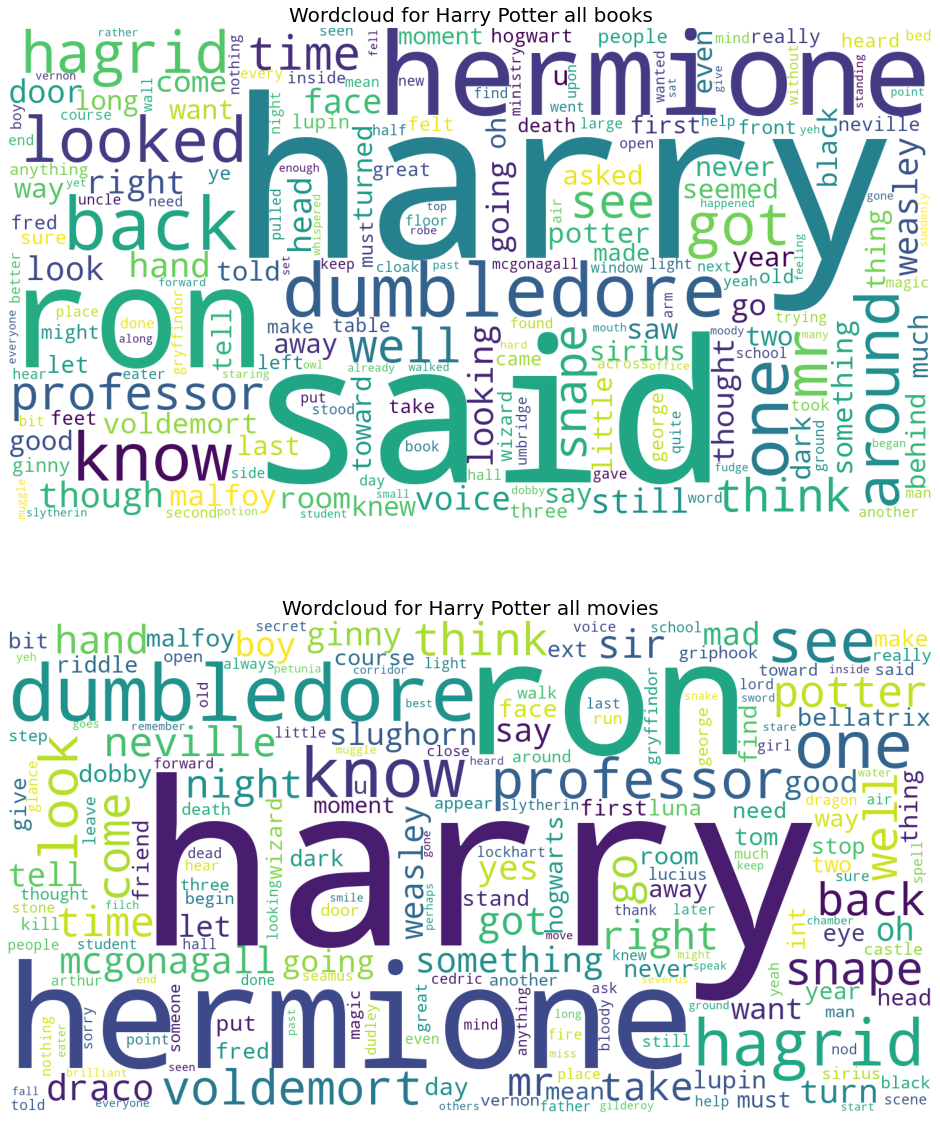

In [ ]:
#Make wordcloud
# change fig size
plt.rcParams['figure.figsize'] = (20, 20) 
plt.rcParams.update({'font.size': 14}) 

wordcloud_books = WordCloud(collocations = False, stopwords = None, background_color="white", width=1500, height=800).generate(HP_books_tokensall)
wordcloud_movies = WordCloud(collocations = False, stopwords = None, background_color="white", width=1500, height=800).generate(HP_movies_tokensall)
plt.subplot(211)
img=plt.imshow(wordcloud_books)
plt.title("Wordcloud for Harry Potter all books", fontsize = 20)
plt.axis("off")
plt.subplot(212)
img=plt.imshow(wordcloud_movies)
plt.title("Wordcloud for Harry Potter all movies", fontsize = 20)
plt.axis("off")
plt.show()

This wordcloud clearly indicates that it is based on texts from books, as it shows a lot of verbs connected with people hearing, talking, seeing, and thinking, such as 'said' and 'know'. The wordcloud for the movies also has a lot of verbs, probably because the actors have to know what to do when playing the scenes.
In both wordclouds, the names of the characters and titles of characters are larger than for the fandom wiki. But 'potter' is not as large as for the fandom wiki, which indicates that both the books and scripts mainly refer to characters by their first names. Especially 'ron' and 'hermione' are both far larger than for fandom wiki .

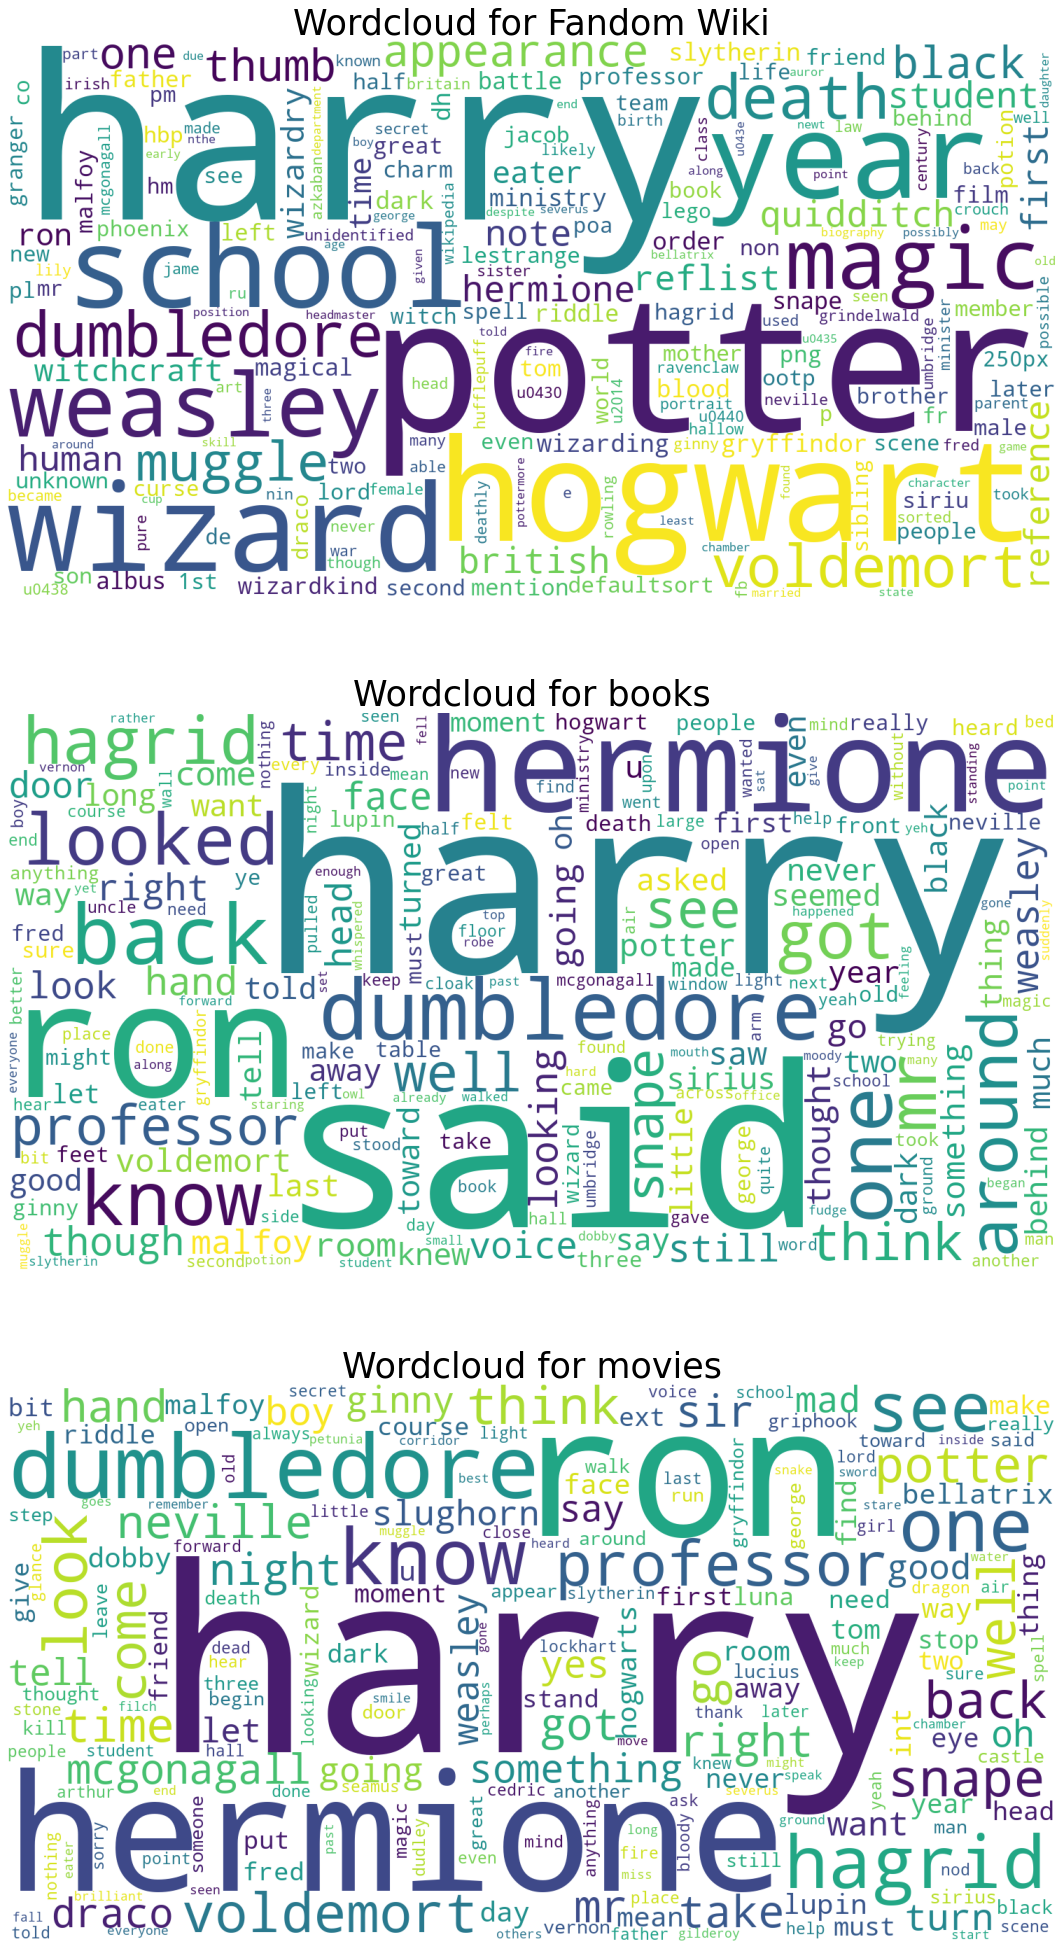

In [ ]:
#Print all three wordclouds for webpage
plt.rcParams['figure.figsize'] = (20, 35) 
plt.rcParams.update({'font.size': 14})

plt.subplot(311)
img=plt.imshow(wordcloud)
plt.title("Wordcloud for Fandom Wiki", fontsize = 35)
plt.axis("off")
plt.subplot(312)
img=plt.imshow(wordcloud_books)
plt.title("Wordcloud for books", fontsize = 35)
plt.axis("off")
plt.subplot(313)
img=plt.imshow(wordcloud_movies)
plt.title("Wordcloud for movies", fontsize = 35)
plt.axis("off")

plt.savefig("wordclouds.png")
plt.show()

#### 3.5.3 Discussion

XXX

### 3.6 Sentiment analysis 

While networks and graphs show a lot of the characters in the universe, the language and words used in the books, movies and on the character pages can say even more about the universe!
The sentiment of the written material can be analyzed. The sentiment analysis can show interesting factors about both the individual characters pages, showing if some sentiment "bias" lie in the used language, but also how the sentiment develops through the books and movies.
In this section we will analyze the character pages to see the level of sentiment used and the differences between the happiest and the saddest characters. Besides this, the sentiment through the books and movie scripts will be analyzed, and some of the main characters' "moods" through the movies will be investigated.

First we need a ranking of happiness for words. Thus we load [LabMT](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752).

In [ ]:
# Import LabMT
LabMT = pd.read_csv('LabMT1.txt', sep= "\t")
LabMT.head()

word  happiness_rank  happiness_average  happiness_standard_deviation  \
0   laughter               1               8.50                        0.9313   
1  happiness               2               8.44                        0.9723   
2       love               3               8.42                        1.1082   
3      happy               4               8.30                        0.9949   
4    laughed               5               8.26                        1.1572   

  twitter_rank google_rank nyt_rank lyrics_rank  
0         3600          --       --        1728  
1         1853        2458       --        1230  
2           25         317      328          23  
3           65        1372     1313         375  
4         3334        3542       --        2332

Then we create a function that can find the sentiment for a given list of words.

In [ ]:
# Create sentiiment function
def sentiment(tokens):
    tokens = [token.lower() for token in tokens]
    fdist = nltk.FreqDist(tokens)
    return pd.DataFrame(tokens, columns=['word']).merge(LabMT, on = 'word').happiness_average.mean()

#### 3.6.1 Fandom and Wikipedia character sentiment
First we look at the sentiment for each charater page. We will analyze the character pages to see the level of sentiment used and the difference between the happiest and the saddest characters.

This will later be related to sentiment of some of the main characters' lines in the scripts of the movies.

As before, the stopwords etc. are removed from each page and the sentiments are calculated with the function.

In [ ]:
#Fandom
page_sentiment = []
# calculate the sentiment for fandom characters
for text in list(HP_fandom_dcc["WikiText"]):
    tmp_list = nltk.regexp_tokenize(text, pattern)
    HP_tokens = [word.lower() for word in tmp_list if word not in string.punctuation and
        word not in stop_words and word not in punct and word not in main_words and word not in inf_words]
    page_sentiment.append(sentiment(HP_tokens))
#Add to dataframe
HP_fandom_dcc["pageSentiment"] = page_sentiment
pickle.dump(HP_fandom_dcc , open( "HP_fandom_dcc_ps.p", "wb" ) )

A histogram is used to see the distribution of sentiment of the character pages for both the Fandom and Wikipedia.

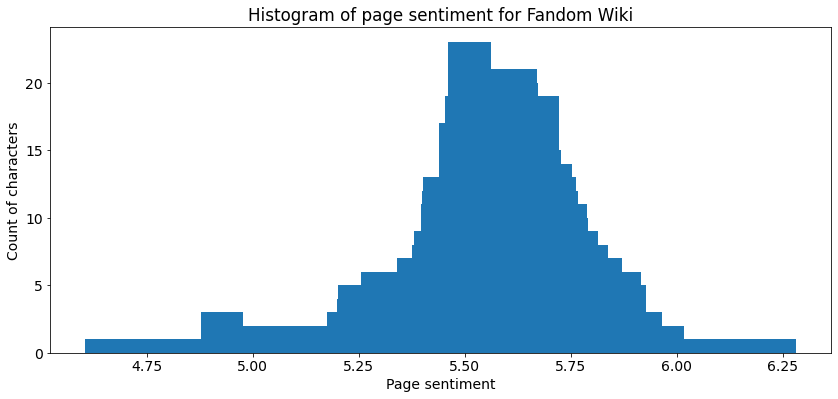

In [ ]:
# change fig size
plt.rcParams['figure.figsize'] = (14, 6) 
plt.rcParams.update({'font.size': 14}) 

#Make histogram
h1, b1 = np.histogram(HP_fandom_dcc["pageSentiment"],bins = 800)
#h2, b2 = np.histogram(HP_wiki["pageSentiment"], bins = 20)
#Define width of bins
width = 0.1
#Define center point of each bin
center1 = (b1[:-1] + b1[1:]) / 2
#center2 = (b2[:-1] + b2[1:]) / 2
#Plot histogram
#plt.subplot(211)
plt.bar(center1, h1, align='center', width=width)
plt.xlabel('Page sentiment')
plt.ylabel('Count of characters')
plt.title('Histogram of page sentiment for Fandom Wiki')
#plt.subplot(212)
#plt.bar(center2, h2, align='center', width=width)
#plt.xlabel('Page sentiment')
#plt.ylabel('Counts og characters')
#plt.title('Histrogram of page sentiment for wikipedia characters pages')
plt.savefig("HistPS.png")
plt.show()

Most of the character pages have a sentiment in the interval $[5;6]$. The histogram almost resamples a normal distribution. The distribution is a bit skewed, with a bit more variation to the left, telling us that the most sad characters are further from the mean than the most happy characters.  
The resemblance of a normal distribution is expected since the text on the fandom wiki is supposed to be written in a natural language. 
To make this more explicit, we take a look at the two end points of the spectre, i.e. we consider the 10 happiest and 10 saddest pages.

First we look at the happiest characters.

In [ ]:
#Fandom
#Find 10 happiest characters 
print("The 10 happpiest characters of fandom are:")
list(HP_fandom_dcc.nlargest(10, "pageSentiment")["CharacterName"])

The 10 happpiest characters of fandom are:


["Constance Pickering's sister",
 "Constance Pickering's mother",
 "Constance Pickering's brother (II)",
 'Nozéa Lestrange',
 "Constance Pickering's brother (I)",
 "Constance Pickering's grandfather",
 "Constance Pickering's grandmother",
 "Ravenclaw Wizard's Chess champion",
 "Unidentified 2000s Hogwarts student's parents",
 'Falco Tremblay']

All of these characters are less popular characters in the universe. Looking into the page of "Constance Pickering's sister", the text is short, making the good words counts more, and words as "mother" and "christmas" both appear, which both have a high rating in the LabMT dataframe. 
Thus it makes sense that pages such as these appear as the happiest.
Looking at the page of "Nozéa Lestrange", the text is also very short and the phrase "By 1927, she had not been married or had any children, and represented the end of her branch of the Lestrange family." appears. Even though this is a less happy sentence, the function understands this as good since words as "married" and "children" occur. Thus it makes less sense that this character is one of the happiest characters. This is an example of how the LabMT is not good at taking negations into account. 

Some of the words that appears on the Constance Pickering's sister page is considered below, showing that they all have a high happiness rating.


In [ ]:
LabMT[LabMT.word.isin(['christmas', 'sister', 'mother', 'dinner'])]

word  happiness_rank  happiness_average  \
31   christmas              32               7.96   
107     mother             108               7.68   
238     dinner             239               7.40   
870     sister             871               6.76   

     happiness_standard_deviation twitter_rank google_rank nyt_rank  \
31                         1.2930          138        3846     2097   
107                        1.6714          626         437      170   
238                        1.1429          245        2292     1328   
870                        1.6483          894        1775      302   

    lyrics_rank  
31          599  
107         549  
238        2344  
870        1003

We then look at the saddest characters.

In [ ]:
#Fandom
#Find 10 saddest characters
print("The 10 saddest characters are:")
list(HP_fandom_dcc.nsmallest(10, "pageSentiment")["CharacterName"])

The 10 saddest characters are:


['Unidentified male Death Eater during the Battle of Hogwarts (IV)',
 'Unidentified Hogsmeade Death Eater (II)',
 'Unidentified Death Eater knocked out by Alastor Moody',
 'Unidentified male bald Death Eater',
 'Unidentified Death Eater killed by Kingsley Shacklebolt',
 'Unidentified Death Eater in the Forbidden Forest',
 'Unidentified Black Death Eater at the Battle of Hogwarts',
 'Unidentified Light Male Death Eater (I)',
 'Unidentified wizard killed at the Quad battlements',
 "Poppy Pomfrey's Death Eater Opponent"]

All of these characters are also minor characters with a short text on their page. 
Just by looking at their names, e.g. containing "knocked out" and "killed", it is easy to see that these characters have a low sentiment.
The fact that all of these, except one, are Death Eaters could also be a strong indication of a low sentiment.

#### 3.6.2 Books and movies

The sentiment of the books and movies are also found and compared. The sentiment of each book and movie (besides movie 5) are calculated. 
As the the last two movies are the last book splitted into two, the two last movies will be added and divided by two, to make it comparable to the books.

In [ ]:
page_sentiment_books = []
page_sentiment_movies = []
# calculate the sentiment for each book
for text in list(HP_books):
    tmp_book_list = nltk.regexp_tokenize(text, pattern)
    HP_book_tokens = [word.lower() for word in tmp_book_list if word not in string.punctuation and
        word not in stop_words and word not in punct and word not in main_words and word not in inf_words]
    page_sentiment_books.append(sentiment(HP_book_tokens))

# calculate the sentiment for each movie
for i in range(len(HP_movies)):
    if i != 4:
        tmp_movie_list = nltk.regexp_tokenize(HP_movies[i], pattern)
        HP_movie_tokens = [word.lower() for word in tmp_movie_list if word not in string.punctuation and
            word not in stop_words and word not in punct and word not in main_words and word not in inf_words]
        page_sentiment_movies.append(sentiment(HP_movie_tokens))
    elif i == 4:
        page_sentiment_movies.append(None)

In [ ]:
#Average last two movies
tmp_sent = (page_sentiment_movies[6]+page_sentiment_movies[7])/2
#Make new list of movies
page_sentiment_movies_new = page_sentiment_movies[0:6]
page_sentiment_movies_new.append(tmp_sent)

And the values are printed.

In [ ]:
print('Sentiment of each book:')
for j,i in zip(range(len(page_sentiment_books)),page_sentiment_books):
    print(' {}: {}'.format(j+1,i))

Sentiment of each book:
 1: 5.488180069686411
 2: 5.4451931231208075
 3: 5.4482956971588115
 4: 5.472665804436987
 5: 5.458627437110395
 6: 5.468555225964056
 7: 5.414841974678848


In [ ]:
print('Sentiment of each movie (besides movies 5):')
for j,i in zip(range(len(page_sentiment_movies_new)),page_sentiment_movies_new):
    print(' {}: {}'.format(j+1,i))

Sentiment of each movie (besides movies 5):
 1: 5.505268161013966
 2: 5.459020758768791
 3: 5.453204014668983
 4: 5.5292482736974256
 5: None
 6: 5.544304878048781
 7: 5.4494541861550605


Then for making it easy to compare, the values are plotted.

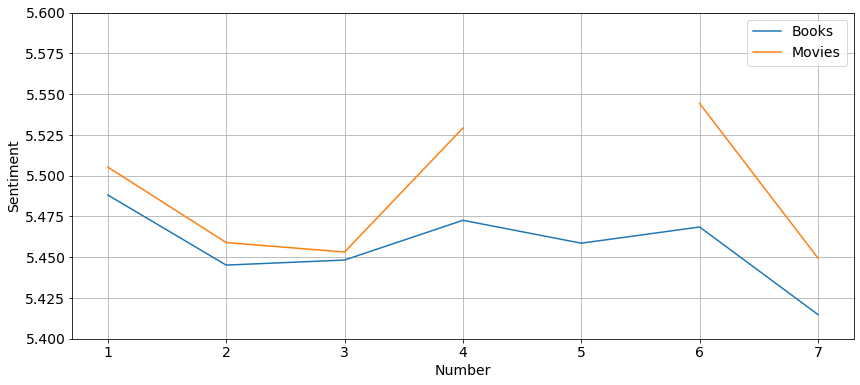

In [ ]:
p1 = plt.plot(range(0,7), page_sentiment_books)
p2 = plt.plot(range(0,7), page_sentiment_movies_new)
plt.ylim(5.4,5.6)
plt.xlabel("Number")
plt.ylabel("Sentiment")
plt.xticks(np.arange(len(page_sentiment_books)), ('1', '2', '3', '4', '5', '6', '7'))
plt.legend((p1[0], p2[0]), ("Books", "Movies"))
plt.grid(True)
plt.show()

As seen on the plot the movies and books follow the same sentiment pattern, but the movies being "more happy" overall.
The highest sentiment for the books is for book 1. An explanation is that the books develop and in pace with this and the characters being older the story being more and more "serious".
The largest difference appears for 4 and 6, which also, whereas the smallest difference is for 3.

#### 3.6.3 Characters Lines in Movies

As a last thing we want to look into the sentiment for some of the main characters line in the movies. 
We want to investigate if there is a difference in sentiment between the characters and over time. 
It will be interesting to see if there is a correlation between how good/evil the characters are and how there sentiment is.
We picked the below characters.

In [ ]:
main_characters_movie_0 = ['McGonagall', 'Dumbledore', 'Harry', 'Dudley', 'Hagrid','Ron','Hermione', 'Neville','Draco','Voldemort','Snape']
main_characters_movie_1 = ['PROFESSOR MCGONAGALL', 'DUMBLEDORE', 'HARRY', 'DUDLEY', 'HAGRID','RON','HERMIONE', 'NEVILLE','DRACO','TOM RIDDLE','SNAPE']
main_characters_movie_2 = ['PROFESSOR MCGONAGALL', 'DUMBLEDORE', 'HARRY', 'DUDLEY', 'HAGRID','RON','HERMIONE', 'NEVILLE','DRACO','VOLDEMORT','SNAPE']
main_characters_movie_3 = ['MCGONAGALL', 'DUMBLEDORE', 'HARRY', 'DUDLEY', 'HAGRID','RON','HERMIONE', 'NEVILLE','DRACO','VOLDEMORT','SNAPE']
main_characters_movie_5 = ['PROFESSOR MCGONAGALL', 'DUMBLEDOR', 'HARRY', 'DUDLEY', 'HAGRID','RON','HERMIONE', 'NEVILLE','MALFOY','TOM RIDDLE','SNAPE']
main_characters_movie_6 = ['MCGONAGALL', 'DUMBLEDORE', 'HARRY', 'DUDLEY', 'HAGRID','RON','HERMIONE', 'NEVILLE','MALFOY','VOLDEMORT','SNAPE']

Then we found the characters lines in the different movies:

In [ ]:
char_sentiment_0 = []
char_sentiment_1 = []
char_sentiment_2 = []
char_sentiment_3 = []
char_sentiment_5 = []
char_sentiment_6 = []
for i in range(len(main_characters_movie_0)):
    char_sentiment_0.append(re.findall(r'\n\n{}(.*?)\n\n'.format(main_characters_movie_0[i]), HP_movies[0]))
    char_sentiment_1.append(re.findall(r'\n\n{}\n\n(.*?)\n\n'.format(main_characters_movie_1[i]), HP_movies[1]))
    char_sentiment_2.append(re.findall(r'\n\n{}\n\n(.*?)\n\n'.format(main_characters_movie_2[i]), HP_movies[2]))
    char_sentiment_3.append(re.findall(r'\n\n{}\n(.*?)\n\n'.format(main_characters_movie_3[i]), HP_movies[3]))
    char_sentiment_5.append(re.findall(r'\n\n{}\n\n(.*?)\n\n'.format(main_characters_movie_5[i]), HP_movies[5]))
    char_sentiment_6.append(re.findall(r'\n\n{}\n\n(.*?\n*.*?)\n\n'.format(main_characters_movie_6[i]), HP_movies[6]))

Then we created a dictionary with alle the lines

In [ ]:
char_sentiment = [char_sentiment_1, char_sentiment_2, char_sentiment_3, char_sentiment_5, char_sentiment_6]
M_char = pd.DataFrame({'Name': ['McGonagall', 'Dumbledore', 'Harry', 'Dudley', 'Hagrid','Ron','Hermione', 'Neville','Draco','Voldemort','Snape'],
                        'Movie 1': char_sentiment_0,
                        'Movie 2': char_sentiment_1,
                        'Movie 3': char_sentiment_2,
                        'Movie 4': char_sentiment_3,
                        'Movie 6': char_sentiment_5,
                        'Movie 7 (part 1)': char_sentiment_6,
                        'Sentiment': None,
                        'aveSentiment': None})

Then we calculated the sentiment for each character in each movie:

In [ ]:
cols = list(M_char.columns)[1:7]
page_sentiment_char = []
s = ', '
# calculate the sentiment for each book
for j in range(len(M_char)):
    ps =[]
    for i in range(len(cols)):
        c = cols[i]
        text = s.join(M_char[c][j])
        tmp_list = nltk.regexp_tokenize(text, pattern)
        M_char_tokens = [word.lower() for word in tmp_list if word not in string.punctuation and
            word not in stop_words and word not in punct and word not in main_words and word not in inf_words]
        ps.append(sentiment(M_char_tokens))
    M_char.Sentiment[j] = ps
    M_char.aveSentiment[j] = np.nanmean(ps)
#save dataframe to load later
pickle.dump(M_char , open( "M_char.p", "wb" ) )

We choose to illustrated the sentiment for each character over time in an graph.

In [ ]:
# Create traces
mx = np.arange(0,7)
fig = go.Figure()
fig.add_trace(go.Scatter(x=mx, y=M_char.Sentiment[0],
                    mode='lines+markers',
                    name=M_char.Name[0]))
fig.add_trace(go.Scatter(x=mx, y=M_char.Sentiment[1],
                    mode='lines+markers',
                    name=M_char.Name[1]))
fig.add_trace(go.Scatter(x=mx, y=M_char.Sentiment[2],
                    mode='lines+markers',
                    name=M_char.Name[2]))
fig.add_trace(go.Scatter(x=mx, y=M_char.Sentiment[3],
                    mode='lines+markers',
                    name=M_char.Name[3]))
fig.add_trace(go.Scatter(x=mx, y=M_char.Sentiment[4],
                    mode='lines+markers',
                    name=M_char.Name[4]))
fig.add_trace(go.Scatter(x=mx, y=M_char.Sentiment[5],
                    mode='lines+markers',
                    name=M_char.Name[5]))
fig.add_trace(go.Scatter(x=mx, y=M_char.Sentiment[6],
                    mode='lines+markers',
                    name=M_char.Name[6]))
fig.add_trace(go.Scatter(x=mx, y=M_char.Sentiment[7],
                    mode='lines+markers',
                    name=M_char.Name[7]))
fig.add_trace(go.Scatter(x=mx, y=M_char.Sentiment[8],
                    mode='lines+markers',
                    name=M_char.Name[8]))
fig.add_trace(go.Scatter(x=mx, y=M_char.Sentiment[9],
                    mode='lines+markers',
                    name=M_char.Name[9]))
fig.add_trace(go.Scatter(x=mx, y=M_char.Sentiment[10],
                    mode='lines+markers',
                    name=M_char.Name[10]))
fig.update_xaxes(
        title_text = "Movie",
        ticktext=["1", "2", "3", "4", "6", "7 (part 1)"],
        tickvals=mx,
        title_font = {"size": 20},
        title_standoff = 25)

fig.update_yaxes(
        title_text = "Sentiment",
        title_font = {"size": 20},
        title_standoff = 25)

fig.update_layout(
    title_text='Character sentiment through movies',
)
fig.write_html('Character-sentiment-through-movies.html')
fig.show()

Then we compare the average sentiment of the movies with the sentiment found from the Fandom pages.

In [ ]:
print('Average sentiment for main characters in the movies: ')
list(M_char.aveSentiment)

Average sentiment for main characters in the movies: 


[5.669606810966811,
 5.656862742205216,
 5.458953523264529,
 5.592225774225775,
 5.439346565986213,
 5.362343819778768,
 5.412892347536217,
 5.404313328915797,
 5.653296869796869,
 5.315328598696115,
 5.447420756791677]

In [ ]:
print('Sentiment for main characters on Fandom Wiki: ')
list(HP_fandom_dcc.pageSentiment[HP_fandom_dcc.CharacterName.isin(['Minerva McGonagall', 'Albus Dumbledore', 'Harry Potter', 'Dudley Dursley', 'Rubeus Hagrid','Ronald Weasley','Hermione Granger', 'Neville Longbottom','Draco Malfoy','Tom Riddle','Severus Snape'])])

Sentiment for main characters on Fandom Wiki: 


[5.523735747820255,
 5.504396222754027,
 5.452114757037834,
 5.402424308907415,
 5.450296603412533,
 5.44667208319792,
 5.492979191896951,
 5.425327896138483,
 5.4978035199363635,
 5.457174402250353,
 5.531076807228916]

The different characters sent

#### 3.6.4 Discussion

XXX

## 4. Discussion. 

- Think critically about your creation
- What went well?,
- What is still missing? What could be improved?, Why?


## 5. Contributions. 

Below the contributions are added to the extended table og content, though all was made in collaboration:

1. Motivation 
2. Data Prepocessing and Basic Stats
    - 2.1 Wikipedia 
	    - 2.1.1 Getting the data using the wiki API
	    - 2.1.2 Creating the Graph
	    - 2.1.3 Baisc Stats
	    - 2.1.4 Visualizing Graph
    - 2.2 Fandom Wiki
	    - 2.2.1 Getting the data using the Fandom wiki API
	    - 2.2.2 Attributes
	    - 2.2.3 Creating the Graph
	    - 2.2.4 Baisc Stats, Loyalty, Blood, Gender, Houses, Graph
		- 2.2.5 Visualizing Graphs
    - 2.3 The Books
    - 2.4 The Movie Scripts
3. Tools, Theory and Analysis
    - 3.1 Degree Distribution
    - 3.2 The Houses
    - 3.4 Blood
    - 3.5 Regular Expressions 
		- 3.5.1 Wordclouds
		- 3.5.2 Books and movies
    - 3.6 Sentiment Analysis
		- 3.6.1 Fandom and wikipedia character sentiment
		- 3.6.2 Books and movies
		- 3.6.3 Characters Lines in Movies
4. Discussion